# Some Data Processing Tools

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math

plt.rcParams.update({
    "figure.facecolor": (1,1,1,1),
    "axes.facecolor": (1,1,1,1),
    "savefig.facecolor": (1,1,1,1)
})

from matplotlib.ticker import ScalarFormatter
import datetime

## File paths 

In [2]:
folder_path = os.path.join("..","Fall2024Data")
flash_data_raw = os.path.join(folder_path, "ASCEND_DATA_2024_11_25_19_13_57.csv")
data2 = os.path.join(folder_path, "DATA2.CSV")
data3 = os.path.join(folder_path, "DATA3.CSV")
data4 = os.path.join(folder_path, "DATA4.CSV")
geiger_data = os.path.join(folder_path, "RadiaCode Log.txt")
geiger_spectrum_xml = os.path.join(folder_path, "RadiaCode_ Spectrum.xml")

aprs_data_csv = os.path.join(folder_path, "aprsfi_KA7NSR-9_data.csv")

# create directory for processed files:
temp_folder = "F24Processed"
os.makedirs(temp_folder, exist_ok=True)

# folder to store graphs
graph_folder = "Graphs"
os.makedirs(graph_folder, exist_ok=True)

In [3]:
def parseHeader(header_field):
    header_field = int(header_field, 16)
    full_no_fail_header = [
      "Header,",
      "Millis,",

      "PCFTime, ", 
      # "DS3231Time,DS3231TempC,",
      "BMETemp(C),BMEPress(hPa),BMEHum(%),BMEGas(KOhms),BMEAlt(m),",    
      # "GeigerSensor(CPS),", 
      "INACurr(mA),INAVolt(mV),INAPow(mW),",                   
      "LSM9DS1 AccX, LSM9DS1 AccY, LSM9DS1 AccZ, LSM9DS1 GyroX, LSM9DS1 GyroY, LSM9DS1 GyroZ, LSM9DS1 MagX, LSM9DS1 MagY, LSM9DS1 MagZ,", 
      # "SHTHum(%), SHTTemp(C),",
      "PicoTemp(C),",
      #"WindADC,TempADC,", 
      "SGPTVOC(ppb),SGPeCO2(ppm),SGPTVOCBase(ppb),SGPeCO2Base(ppb),SGPH2,SGPEtha,",
      "BME280RelHum %,BME280Pres Pa,BME280Alt m,BME280TempC,DewPointC,",  
      "ENSAQI,ENSTVOC ppb,ENSECO2 ppm,",
      "UVA2(nm),UVB2(nm),UVC2(nm),",
      "UVA0(nm),UVB0(nm),UVC0(nm),",
      "ICM AccX,ICM AccY,ICM AccZ,ICM GyroX,ICM GyroY,ICM GyroZ,ICM MagX,ICM MagY,ICM MagZ,ICM TempC,",
      "MTK_Date,MTK_Lat,MTKLong,MTKSpeed,MTKAngle,MTKAlt,MTKSats,",
      " "  # final space for matching fsw?
    ]
    header_bin = bin(header_field)[2:]
    header_bin = header_bin[header_bin.find("1"):] # trim to first 1
    header = "Receive time, "
    for i in range(len(header_bin)): # add each from full header if 1
        if header_bin[i] == "1": header += full_no_fail_header[i]
    return header

## Getting Data

In [4]:
# get flash data
flash_data = os.path.join(temp_folder, "flash_data_header.csv")
with open(flash_data_raw, "r") as fin, open(flash_data, "w") as fout:
    finlist = list(fin)
    fout.write(parseHeader(finlist[0].split(",")[1]) + "\n")
    for line in finlist:
        if(line.split(",")[1] == " 3f82" and line.split(",")[3].find("2005") != -1):
            break
        if(line.split(",")[1] == " 3f82"):
            fout.write(line)

In [5]:
custom_na = pd._libs.parsers.STR_NA_VALUES
custom_na.add("-")
flash_df = pd.read_csv(flash_data, skipinitialspace=True, na_values=custom_na)

original_flash_df = flash_df.copy()

flash_df["BMEGas(KOhms)"] = [i / 1000.0 for i in flash_df["BMEGas(KOhms)"]]
flash_df["Minutes(millis)"] = [i / 1000 / 60 for i in flash_df["Millis"]]
flash_df["LSM Accel Mag"] = [math.sqrt(x**2 + y**2 + z**2)/8 for x,y,z in zip(flash_df["LSM9DS1 AccX"], flash_df["LSM9DS1 AccY"], flash_df["LSM9DS1 AccZ"])]
flash_df["ICM Accel Mag"] = [math.sqrt(x**2 + y**2 + z**2)/8 for x,y,z in zip(flash_df["ICM AccX"], flash_df["ICM AccY"], flash_df["ICM AccZ"])]
flash_df["BMEGas Adj"] = [(flash_df["BMEGas(KOhms)"][i] * abs(25 / flash_df["BMETemp(C)"][i]) * (flash_df["BMEHum(%)"][i] / 50)) for i in range(len(flash_df["BMEGas(KOhms)"]))]

print(list(flash_df.columns))


['Receive time', 'Header', 'Millis', 'PCFTime', 'BMETemp(C)', 'BMEPress(hPa)', 'BMEHum(%)', 'BMEGas(KOhms)', 'BMEAlt(m)', 'INACurr(mA)', 'INAVolt(mV)', 'INAPow(mW)', 'LSM9DS1 AccX', 'LSM9DS1 AccY', 'LSM9DS1 AccZ', 'LSM9DS1 GyroX', 'LSM9DS1 GyroY', 'LSM9DS1 GyroZ', 'LSM9DS1 MagX', 'LSM9DS1 MagY', 'LSM9DS1 MagZ', 'PicoTemp(C)', 'ICM AccX', 'ICM AccY', 'ICM AccZ', 'ICM GyroX', 'ICM GyroY', 'ICM GyroZ', 'ICM MagX', 'ICM MagY', 'ICM MagZ', 'ICM TempC', 'Unnamed: 32', 'Minutes(millis)', 'LSM Accel Mag', 'ICM Accel Mag', 'BMEGas Adj']


In [6]:
# merging in APRS data to the dataframe
aprs_df = pd.read_csv(aprs_data_csv)

"""
From radio data:
receive time = 9:46:55 
PCFTime = 5:1:19 
general so ignore seconds
PCFTime -> receive time 
hours -> hours + 4
minutes -> minutes + 45
then APRS is in utc so 
MST to UTC is 
hours -> hours + 7
"""
def fixTimeUTC(bad_time):
    tokens = bad_time.split(":")
    return f"{(int(tokens[0])+4+7+((int(tokens[1])+45)//60))%24}:{(int(tokens[1])+45)%60}:{(int(tokens[2])+0)%60}"

def fixTimeMST(bad_time):
    tokens = bad_time.split(":")
    return f"{(int(tokens[0])+4+((int(tokens[1])+45)//60))%24}:{(int(tokens[1])+45)%60}:{(int(tokens[2])+0)%60}"
      
        
aprs_index = 0
lat = []
long = []
speed = []
course = []
altitude = []
for i in range(len(flash_df["PCFTime"])):
    # for each time if it 
    
    if str(flash_df["PCFTime"][i]) == "nan" or aprs_index >= len(aprs_df["time"]):
        lat.append(np.nan)
        long.append(np.nan)
        speed.append(np.nan)
        course.append(np.nan)
        altitude.append(np.nan)
        continue
        
    flash_time = datetime.datetime.strptime(fixTimeUTC((flash_df["PCFTime"][i]).split()[1]), "%H:%M:%S")
    aprs_time = datetime.datetime.strptime(aprs_df["time"][aprs_index].split()[1], "%H:%M:%S")
    
    if aprs_time < flash_time:
        lat.append(aprs_df["lat"][aprs_index])
        long.append(aprs_df["lng"][aprs_index])
        speed.append(aprs_df["speed"][aprs_index])
        course.append(aprs_df["course"][aprs_index])
        altitude.append(aprs_df["altitude"][aprs_index])
#         print("Attached", aprs_df["time"][aprs_index], "to PCF Time", flash_df["PCFTime"][i], f"({fixTimeUTC((flash_df['PCFTime'][i]).split()[1])})")
        
        aprs_index += 1
    else:
        lat.append(np.nan)
        long.append(np.nan)
        speed.append(np.nan)
        course.append(np.nan)
        altitude.append(np.nan)

print("Successfully merged", aprs_index, "data points from APRS")

flash_df["aprs lat"] = lat
flash_df["aprs long"] = long
flash_df["aprs speed"] = speed
flash_df["aprs course"] = course
flash_df["aprs altitude"] = altitude

# merge geiger data 
geiger_csv_path = os.path.join(temp_folder, "geiger.csv")
with open(geiger_csv_path, "w") as fout, open(geiger_data, "r") as fin:
    for line in fin:
        line = line.replace(",", ":")
        line = line.replace(";", ",")
        fout.write(line)
        
geiger_df = pd.read_csv(geiger_csv_path, skipinitialspace=True, skiprows=range(1,15))
# add "Just Time" column
geiger_df["Just Time"] = [i.split()[1] for i in geiger_df["Time"]]

# print(list(geiger_df.columns))
cps = []
dose_rate = [] 
dose_rate_error = []

geiger_index = 0
for i in range(len(flash_df["PCFTime"])):
    # for each time if it 
    
    if str(flash_df["PCFTime"][i]) == "nan" or geiger_index >= len(geiger_df["Time"]):
        cps.append(np.nan)
        dose_rate.append(np.nan)
        dose_rate_error.append(np.nan)
        continue
        
    flash_time = datetime.datetime.strptime(fixTimeMST((flash_df["PCFTime"][i]).split()[1]), "%H:%M:%S")
    aprs_time = datetime.datetime.strptime(geiger_df["Time"][geiger_index].split()[1].split(".")[0], "%H:%M:%S")
    
    if aprs_time < flash_time:
        cps.append(geiger_df["Count Rate: cps"][geiger_index])
        dose_rate.append(geiger_df["Dose rate: Sv/h"][geiger_index])
        dose_rate_error.append(geiger_df["Dose Rate Error: %"][geiger_index])
#         print("Attached", geiger_df["Time"][geiger_index], "to PCF Time", flash_df["PCFTime"][i], f"({fixTimeMST((flash_df['PCFTime'][i]).split()[1])})")
        
        geiger_index += 1
    else:
        cps.append(np.nan)
        dose_rate.append(np.nan)
        dose_rate_error.append(np.nan)
        
flash_df["geiger cps"] = cps
flash_df["geiger dose rate Sv/h"] = dose_rate
flash_df["geiger rate error %"] = dose_rate_error
     
print("Successfully merged", geiger_index, "data points from RadiaCode")

print("\nFull Dataframe: ")
print(list(flash_df.columns))




Successfully merged 45 data points from APRS
Successfully merged 234 data points from RadiaCode

Full Dataframe: 
['Receive time', 'Header', 'Millis', 'PCFTime', 'BMETemp(C)', 'BMEPress(hPa)', 'BMEHum(%)', 'BMEGas(KOhms)', 'BMEAlt(m)', 'INACurr(mA)', 'INAVolt(mV)', 'INAPow(mW)', 'LSM9DS1 AccX', 'LSM9DS1 AccY', 'LSM9DS1 AccZ', 'LSM9DS1 GyroX', 'LSM9DS1 GyroY', 'LSM9DS1 GyroZ', 'LSM9DS1 MagX', 'LSM9DS1 MagY', 'LSM9DS1 MagZ', 'PicoTemp(C)', 'ICM AccX', 'ICM AccY', 'ICM AccZ', 'ICM GyroX', 'ICM GyroY', 'ICM GyroZ', 'ICM MagX', 'ICM MagY', 'ICM MagZ', 'ICM TempC', 'Unnamed: 32', 'Minutes(millis)', 'LSM Accel Mag', 'ICM Accel Mag', 'BMEGas Adj', 'aprs lat', 'aprs long', 'aprs speed', 'aprs course', 'aprs altitude', 'geiger cps', 'geiger dose rate Sv/h', 'geiger rate error %']


In [7]:
from tabulate import tabulate
from IPython.display import HTML, display

# datarate 
row_count = len(flash_df["Millis"])
millis_dur = flash_df["Millis"][row_count-1] - flash_df["Millis"][0]
sample_period = round((millis_dur/1000) / row_count, 2)

ignores = ["Receive time", "Header"]
sample_counts = list(original_flash_df.count())

print("Data Collection Stats:")
print("Recorded", len(flash_df["Millis"]), "rows", end=" ")
print("over", round(millis_dur / 1000 / 60, 2), "minutes")
print(len(flash_df.columns), "columns per row")
print(sum(sample_counts[2:]), "data points")
print()
print("Overall Sample Period:", sample_period, "seconds")
print("Overall Sample Frequency:", round(1/sample_period, 2), "Hz")
print()

table_list = [["Data Name", "Number of Samples", "Average Sample Frequency (Hz)", "Average Sample Period (s)", "Best Sample Period (s)", "Worst Sample Period (s)"]]

print("Analyzing Data", end="")
for i, col in enumerate(list(original_flash_df.columns)):
    if sample_counts[i] == 0 or (col in ignores): continue
    best_period = 10000
    worst_period = 0
    # find them
    last_found = -1
    print(".", end="")
    for r, val in enumerate(original_flash_df[col]):
        if str(val) != "nan":
            if last_found != -1:
                this_period = original_flash_df["Millis"][r] - last_found
#                 if(best_period != min(best_period, this_period)): print(original_flash_df["Millis"][r], best_period)
                best_period = min(best_period, this_period)
                worst_period = max(worst_period, this_period)
            last_found = original_flash_df["Millis"][r]
    best_period /= 1000
    worst_period /= 1000
            
    average_period = (millis_dur / 1000) / sample_counts[i] 
    average_frequency = 1 / average_period 
    
    entry = [col, sample_counts[i], round(average_frequency, 3), round(average_period, 3), best_period, worst_period]
    
    table_list.append(entry)

def device_filter(data):
    row_names = [table_list[i][0] for i in range(1, len(table_list))]
    device_id_str = ["PCF", "BME", "INA", "LSM", "Pico", "ICM"]
    new_data = []
    for device_id in device_id_str:
        index = 0
        while device_id not in row_names[index] and index < len(row_names):
            index += 1
        new_data.append(data[index])
    return new_data
    

table_list.append(["By Device Average"] + [round(np.mean(device_filter([table_list[i][j] for i in range(1, len(table_list))])), 3) for j in range(1, len(table_list[0]))])
table_list.append(["By Device Min"] + [round(np.min(device_filter([table_list[i][j] for i in range(1, len(table_list))])), 3) for j in range(1, len(table_list[0]))])
table_list.append(["By Device Max"] + [round(np.max(device_filter([table_list[i][j] for i in range(1, len(table_list))])), 3) for j in range(1, len(table_list[0]))])


print("Done.")


Data Collection Stats:
Recorded 8456 rows over 80.75 minutes
45 columns per row
211400 data points

Overall Sample Period: 0.57 seconds
Overall Sample Frequency: 1.75 Hz

Analyzing Data..............................Done.


In [8]:
table_html = tabulate(
    table_list,
    tablefmt="html",
    headers="firstrow"
)

display(HTML(table_html))

Data Name,Number of Samples,Average Sample Frequency (Hz),Average Sample Period (s),Best Sample Period (s),Worst Sample Period (s)
Millis,8456,1.745,0.573,0.147,1.151
PCFTime,4228,0.873,1.146,1.091,2.105
BMETemp(C),4228,0.873,1.146,1.091,2.105
BMEPress(hPa),4228,0.873,1.146,1.091,2.105
BMEHum(%),4228,0.873,1.146,1.091,2.105
BMEGas(KOhms),4228,0.873,1.146,1.091,2.105
BMEAlt(m),4228,0.873,1.146,1.091,2.105
INACurr(mA),4228,0.873,1.146,1.091,2.105
INAVolt(mV),4228,0.873,1.146,1.091,2.105
INAPow(mW),4228,0.873,1.146,1.091,2.105


## General Functions
The idea is to have an array of functions that can be applied to a plot to add information to it

### Finding keypoints for shading 

In [9]:
# based on altitude, stamped by Minutes(millis) and Pressure
shaders = [None,None,None,None,None,None,None,]
altitude_m_col = "BMEAlt(m)"
# launch
initial_alt = flash_df[altitude_m_col][0]
print("Initial Altitude: ", initial_alt, "m")
index = 0
threshold = 10
while str(flash_df[altitude_m_col][index]) == "nan" or flash_df[altitude_m_col][index] < initial_alt + threshold:
    index += 1 
launch_index = index
print("Launch time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
shaders[0] = ("Launch", 
                flash_df["Minutes(millis)"][index], 
                flash_df["Minutes(millis)"][index]+1,
                flash_df["BMEPress(hPa)"][index],
                flash_df["BMEPress(hPa)"][index]+50,
                "green", 1.0)

# burst 
index = flash_df[altitude_m_col].idxmax()
print("Burst time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
shaders[1] = ("Burst", 
                flash_df["Minutes(millis)"][index]-1, 
                flash_df["Minutes(millis)"][index], 
                flash_df["BMEPress(hPa)"][index]-0.5,
                flash_df["BMEPress(hPa)"][index],
                "red", 1.0)

# troposphere
troposphere_top = 12_000
index = launch_index
while str(flash_df[altitude_m_col][index]) == "nan" or flash_df[altitude_m_col][index] < troposphere_top:
    index += 1
print("Troposphere Exit Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
shaders[2] = ("Troposphere", 
                flash_df["Minutes(millis)"][0], 
                flash_df["Minutes(millis)"][index],
                flash_df["BMEPress(hPa)"][0],
                flash_df["BMEPress(hPa)"][index],
                "skyblue", 0.15)

# tropopause
tropopause_top = 12_500
print("Tropopause Enter Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
start_index = index 
while str(flash_df[altitude_m_col][index]) == "nan" or flash_df[altitude_m_col][index] < tropopause_top:
    index += 1
print("Tropopause Exit Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
shaders[3] = ("Tropopause", 
                flash_df["Minutes(millis)"][start_index], 
                flash_df["Minutes(millis)"][index],
                flash_df["BMEPress(hPa)"][start_index],
                flash_df["BMEPress(hPa)"][index],
                "steelblue", 0.15)

# stratosphere before ozone layer
print("Stratosphere Enter Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
start_index = index
ozone_bottom = 15_000
ozone_top = 35_000
while str(flash_df[altitude_m_col][index]) == "nan" or flash_df[altitude_m_col][index] < ozone_bottom:
    index += 1
    
print("Stratosphere To Ozone Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
shaders[4] = ("Stratosphere", 
                flash_df["Minutes(millis)"][start_index], 
                flash_df["Minutes(millis)"][index],
                flash_df["BMEPress(hPa)"][start_index],
                flash_df["BMEPress(hPa)"][index],
                "dodgerblue", 0.15)

# ozone layer
print("Ozone Enter Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
start_index = index 

while index < len(flash_df[altitude_m_col])-1 and (str(flash_df[altitude_m_col][index]) == "nan" or flash_df[altitude_m_col][index] < ozone_top):
    index += 1
print("Ozone Exit Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
shaders[5] = ("Ozone Layer", 
                flash_df["Minutes(millis)"][start_index], 
                flash_df["Minutes(millis)"][index],
                flash_df["BMEPress(hPa)"][start_index],
                flash_df["BMEPress(hPa)"][index],
                "midnightblue", 0.15)

# stratosphere after ozone layer
print("Ozone to Stratosphere Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
start_index = index 
# index = flash_df["Minutes(millis)"].idxmax()
while index < len(flash_df[altitude_m_col])-1 and (str(flash_df[altitude_m_col][index]) == "nan" or flash_df[altitude_m_col][index] > tropopause_top):
    index += 1
print("Stratosphere Exit Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")

if start_index == len(flash_df[altitude_m_col])-1: time_start = np.nan
else: time_start = flash_df["Minutes(millis)"][start_index]
if index == len(flash_df[altitude_m_col])-1: time_end = np.nan
else: time_end = flash_df["Minutes(millis)"][index]

shaders[6] = ("Stratosphere", 
                time_start, 
                time_end,
                flash_df["BMEPress(hPa)"][start_index],
                flash_df["BMEPress(hPa)"][index],
                "dodgerblue", 0.15)

print("\nFills:")
print(*shaders, sep="\n")


Initial Altitude:  532.37 m
Launch time:  17.636366666666667 (alt = 544.56)
Burst time:  81.89576666666667 (alt = 26729.37)
Troposphere Exit Time:  43.1789 (alt = 12006.17)
Tropopause Enter Time:  43.1789 (alt = 12006.17)
Tropopause Exit Time:  44.16321666666667 (alt = 12504.23)
Stratosphere Enter Time:  44.16321666666667 (alt = 12504.23)
Stratosphere To Ozone Time:  48.673300000000005 (alt = 15004.82)
Ozone Enter Time:  48.673300000000005 (alt = 15004.82)
Ozone Exit Time:  82.1829 (alt = nan)
Ozone to Stratosphere Time:  82.1829 (alt = nan)
Stratosphere Exit Time:  82.1829 (alt = nan)

Fills:
('Launch', 17.636366666666667, 18.636366666666667, 949.84, 999.84, 'green', 1.0)
('Burst', 80.89576666666667, 81.89576666666667, 7.41, 7.91, 'red', 1.0)
('Troposphere', 1.4375833333333332, 43.1789, 950.92, 192.86, 'skyblue', 0.15)
('Tropopause', 43.1789, 44.16321666666667, 192.86, 177.73, 'steelblue', 0.15)
('Stratosphere', 44.16321666666667, 48.673300000000005, 177.73, 115.61, 'dodgerblue', 0.15

### Plot with Pressure as the X-axis

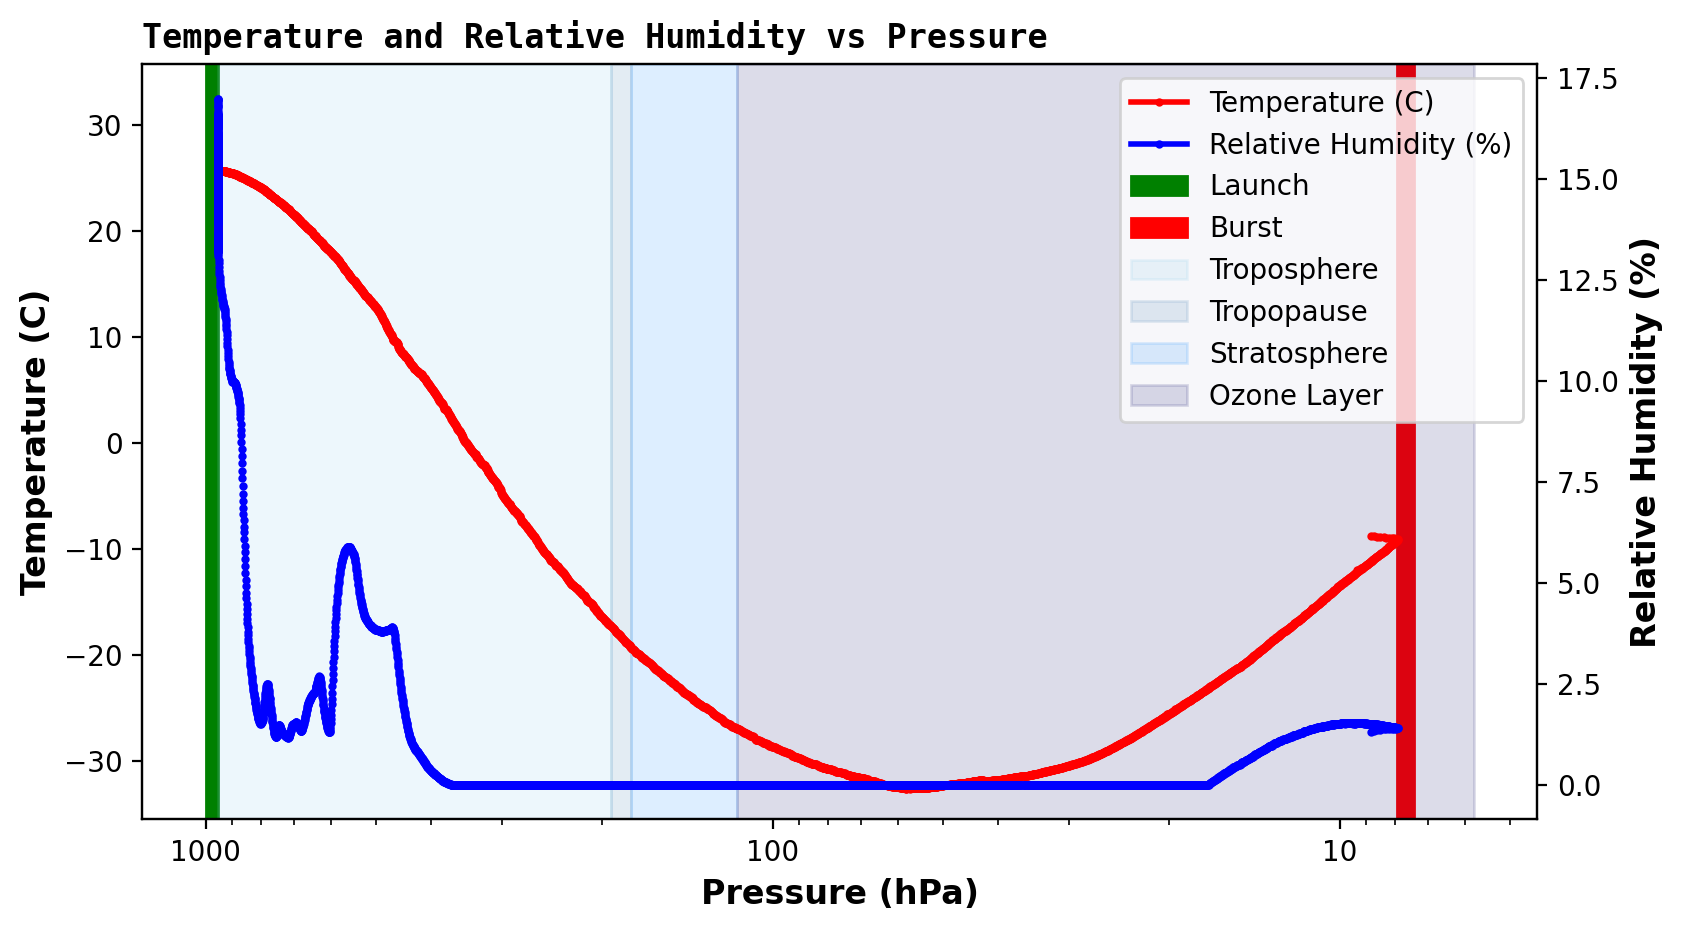

In [10]:
def pressurePlot(df, pressure_col, unit, var1, var2, fills):
    fig, ax = plt.subplots(dpi=200)
    fig.set_figwidth(9)
    fig.set_figheight(5)
    
    plt.title(f"{var1[1]} and {var2[1]} vs Pressure", fontsize="large", loc="left", fontweight="bold", family="monospace")
    plt.xscale("log")
    
    ax.set_xlabel(f"Pressure ({unit})", fontsize="large", fontweight="bold")
    ax.set_ylabel(f"{var1[1]} ({var1[2]})", fontsize="large", fontweight="bold")
    line1 = plt.plot(pressure_col, var1[0], data=df, marker='o', markersize=2, color=var1[3], linewidth=2, label=f"{var1[1]} ({var1[2]})")    
    
    ax2 = ax.twinx()
    ax2.set_ylabel(f"{var2[1]} ({var2[2]})", fontsize="large", fontweight="bold")
    line2 = plt.plot(pressure_col, var2[0], data=df, marker='o', markersize=2, color=var2[3], linewidth=2, label=f"{var2[1]} ({var2[2]})")
    
    ax.set_ylim([None, ax.get_ylim()[1] * 1.25]);
    ax.invert_xaxis()
#     ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    
    legendObj = line1 + line2
    legendLabels = [line1[0].get_label(), line2[0].get_label()]
    
    top = ax.get_ylim()[1]
    bottom = ax.get_ylim()[0]
    for fill in fills: 
        if str(fill[3]) == "nan": continue
        xstart = fill[3]
        if str(fill[4]) != "nan": xstop = fill[4]
        else: xstop = ax.get_xlim()[1]
        fill1 = ax.fill([xstart, xstop, xstop, xstart],[top, top, bottom, bottom], alpha=fill[6], label=fill[0], color=fill[5])
        legendObj += fill1
        legendLabels.append(fill1[0].get_label())
    ax.legend(legendObj, legendLabels, loc='upper right')
    
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(f'{var1[1]} and {var2[1]}'.split())}_vs_pressure.svg"))
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(f'{var1[1]} and {var2[1]}'.split())}_vs_pressure.png"))
    
    plt.show()

pressurePlot(flash_df, "BMEPress(hPa)", "hPa", ("BMETemp(C)", "Temperature", "C", "red"), 
                                        ("BMEHum(%)", "Relative Humidity", "%", "blue"), shaders)



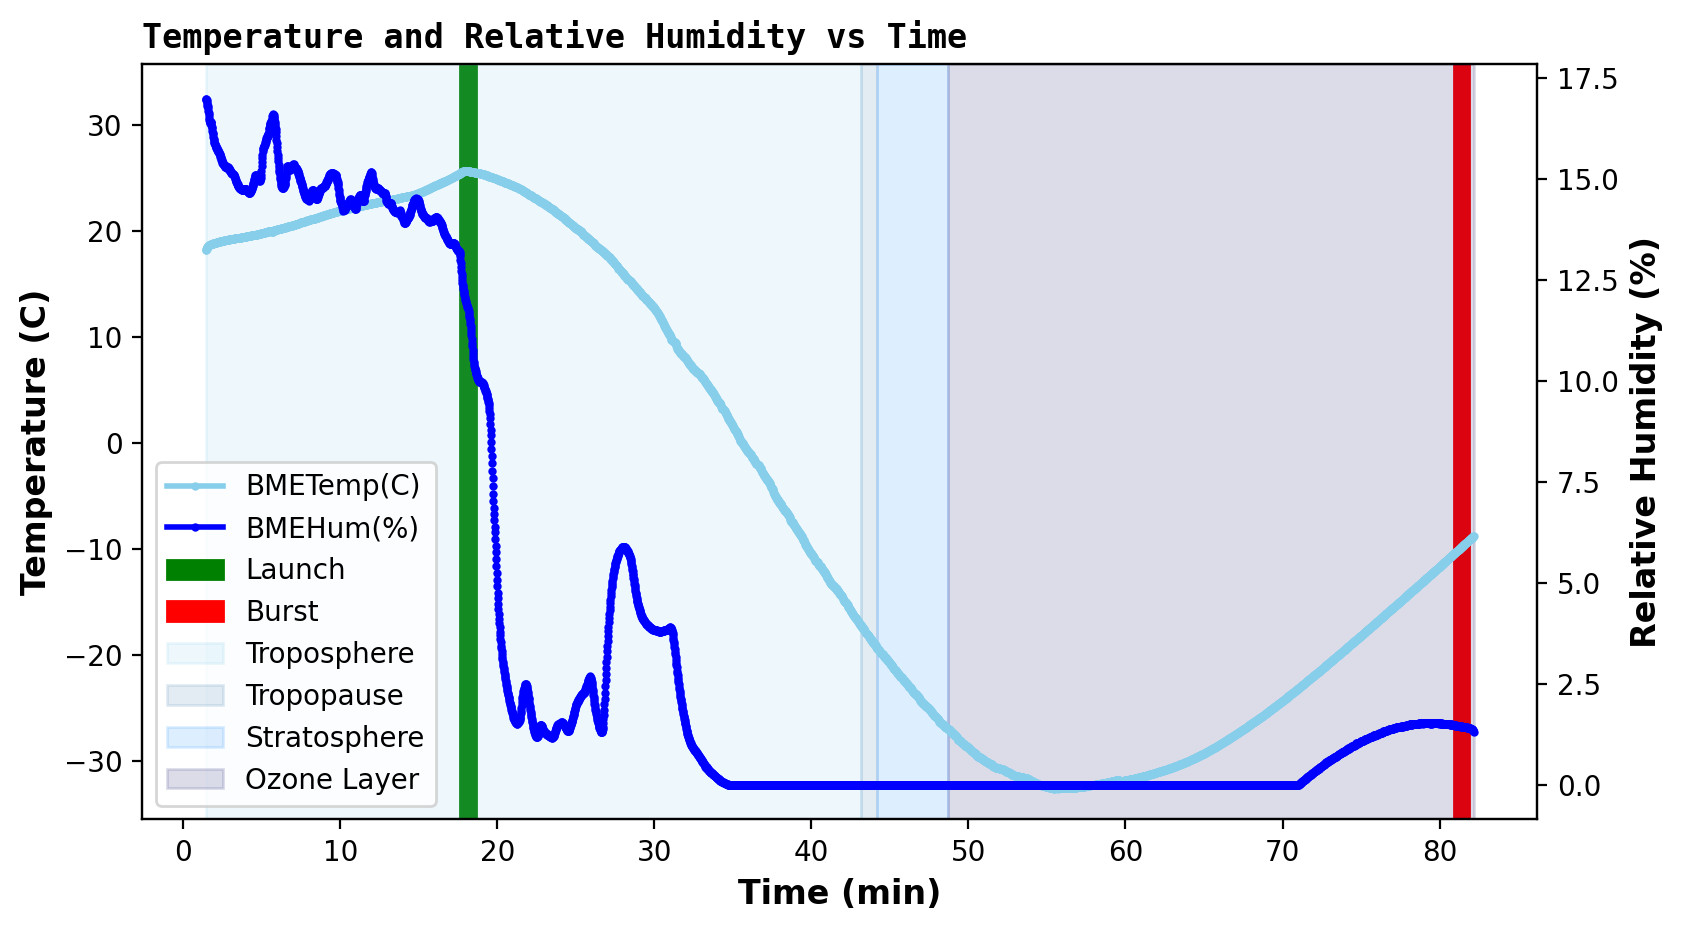

In [11]:
def timePlot(df, time_col, unit, var1, var2, fills):
    fig, ax = plt.subplots(dpi=200)
    fig.set_figwidth(9)
    fig.set_figheight(5)
    
    if(var2 != None):
        plot_title = f"{var1[1]} and {var2[1]} vs Time"
    else:
        plot_title = f"{var1[1]} vs Time"
    
    plt.title(plot_title, fontsize="large", loc="left", fontweight="bold", family="monospace")
    
    ax.set_xlabel(f"Time ({unit})", fontsize="large", fontweight="bold")
    ax.set_ylabel(f"{var1[1]} ({var1[2]})", fontsize="large", fontweight="bold")
    line1 = plt.plot(time_col, var1[0], data=df, marker='o', markersize=2, color=var1[3], linewidth=2)    
    
    if(var2 != None):
        ax2 = ax.twinx()
        ax2.set_ylabel(f"{var2[1]} ({var2[2]})", fontsize="large", fontweight="bold")
        line2 = plt.plot(time_col, var2[0], data=df, marker='o', markersize=2, color=var2[3], linewidth=2)

    ax.set_ylim([None, ax.get_ylim()[1] * 1.25]);
    
    if(var2 != None):
        legendObj = line1 + line2
        legendLabels = [line1[0].get_label(), line2[0].get_label()]
    else:
        legendObj = line1
        legendLabels = [line1[0].get_label()]

    top = ax.get_ylim()[1]
    bottom = ax.get_ylim()[0]
    for fill in fills: 
        if str(fill[1]) == "nan": continue
        xstart = fill[1]
        if str(fill[2]) != "nan": xstop = fill[2]
        else: xstop = ax.get_xlim()[1]
        fill1 = ax.fill([xstart, xstop, xstop, xstart],[top, top, bottom, bottom], alpha=fill[6], label=fill[0], color=fill[5])
        legendObj += fill1
        legendLabels.append(fill1[0].get_label())
    ax.legend(legendObj, legendLabels)
    
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(plot_title.split())}.svg"))
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(plot_title.split())}.png"))
    
    plt.show()

timePlot(flash_df, "Minutes(millis)", "min", ("BMETemp(C)", "Temperature", "C", "skyblue"), 
                                        ("BMEHum(%)", "Relative Humidity", "%", "blue"), shaders)


In [12]:
def customPlot(df, 
               x_axis, x_col,
               left_y_axis, left_y_cols, 
               right_y_axis = None, right_y_cols = None,
               fills = None, fills_index_offset = 0, reverse_and_log = False, x_ticks=None):
    fig, ax = plt.subplots(dpi=200)
    fig.set_figwidth(9)
    fig.set_figheight(5)
    
    if(right_y_axis != None):
        plot_title = f"{', '.join([i[1] for i in left_y_cols])} and {', '.join([i[1] for i in right_y_cols])} vs {x_axis[0]}"
    else:
        plot_title = f"{', '.join([i[1] for i in left_y_cols])} vs {x_axis[0]}"
    plt.title(plot_title, fontsize="large", loc="left", fontweight="bold", family="monospace", x=0.07)
    
    if(x_axis[1] == ""):
        ax.set_xlabel(f"{x_axis[0]}", fontsize="large", fontweight="bold")
    else:
        ax.set_xlabel(f"{x_axis[0]} ({x_axis[1]})", fontsize="large", fontweight="bold")
    
    if x_ticks != None:
        ax.xaxis.set_major_locator(plt.MaxNLocator(x_ticks))
    
    legendObj = []
    legendLabels = []
    
    ax.set_ylabel(f"{left_y_axis[0]} ({left_y_axis[1]})", fontsize="large", fontweight="bold")
    for col in left_y_cols:
        line = plt.plot(x_col, col[0], data=df, marker='o', markersize=4, color=col[2], linewidth=2, label=f"{col[1]} ({left_y_axis[1]})") 
        legendObj += line
        legendLabels.append(line[0].get_label())
    
    if(right_y_axis != None):
        ax2 = ax.twinx()
        
        ax2.set_ylabel(f"{right_y_axis[0]} ({right_y_axis[1]})", fontsize="large", fontweight="bold")
        for col in right_y_cols: 
            line = plt.plot(x_col, col[0], data=df, marker='o', markersize=4, color=col[2], linewidth=2, label=f"{col[1]} ({right_y_axis[1]})")
            legendObj += line
            legendLabels.append(line[0].get_label())
    
    ax.set_ylim([None, ax.get_ylim()[1] * 1.25]);
    if(reverse_and_log):
        plt.xscale("log")
        ax.invert_xaxis()
        ax.xaxis.set_major_formatter(ScalarFormatter())
    
    if fills != None:
        top = ax.get_ylim()[1]
        bottom = ax.get_ylim()[0]
        for fill in fills:
            if str(fill[1+fills_index_offset]) == "nan": continue
            xstart = fill[1+fills_index_offset]
            if str(fill[2+fills_index_offset]) != "nan": xstop = fill[2+fills_index_offset]
            else: xstop = ax.get_xlim()[1]
            fill1 = ax.fill([xstart, xstop, xstop, xstart],[top, top, bottom, bottom], alpha=fill[-1], label=fill[0], color=fill[-2])
            legendObj += fill1
            legendLabels.append(fill1[0].get_label())
    
    ax.legend(legendObj, legendLabels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(plot_title.replace('/', '').replace(',','').split())}.svg"), bbox_inches='tight')
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(plot_title.replace('/', '').replace(',','').split())}.png"), bbox_inches='tight')
    
    plt.show()
    

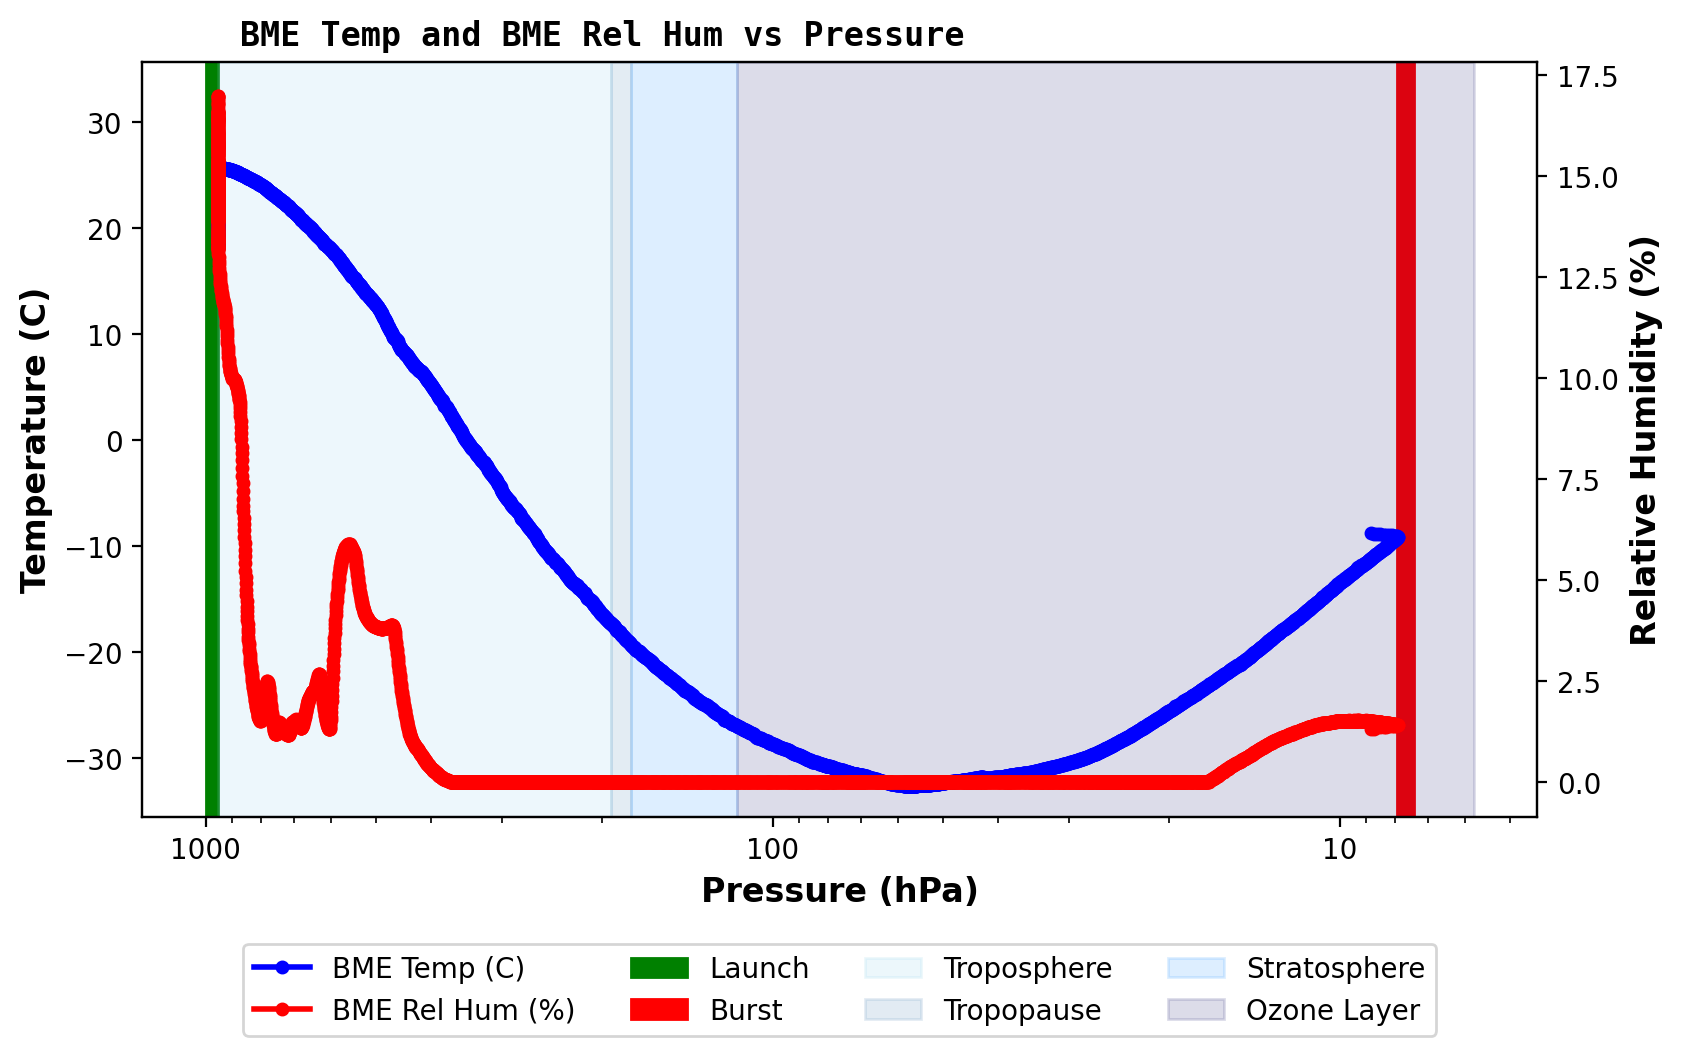

In [13]:
customPlot(df = flash_df, 
           x_axis = ("Pressure", "hPa"),
           x_col = "BMEPress(hPa)",
           left_y_axis = ("Temperature", "C"),
           left_y_cols = [("BMETemp(C)", "BME Temp", "blue")],
           right_y_axis = ("Relative Humidity", "%"), 
           right_y_cols = [("BMEHum(%)", "BME Rel Hum", "red")],
           fills = shaders, 
           fills_index_offset = 2, 
           reverse_and_log = True)


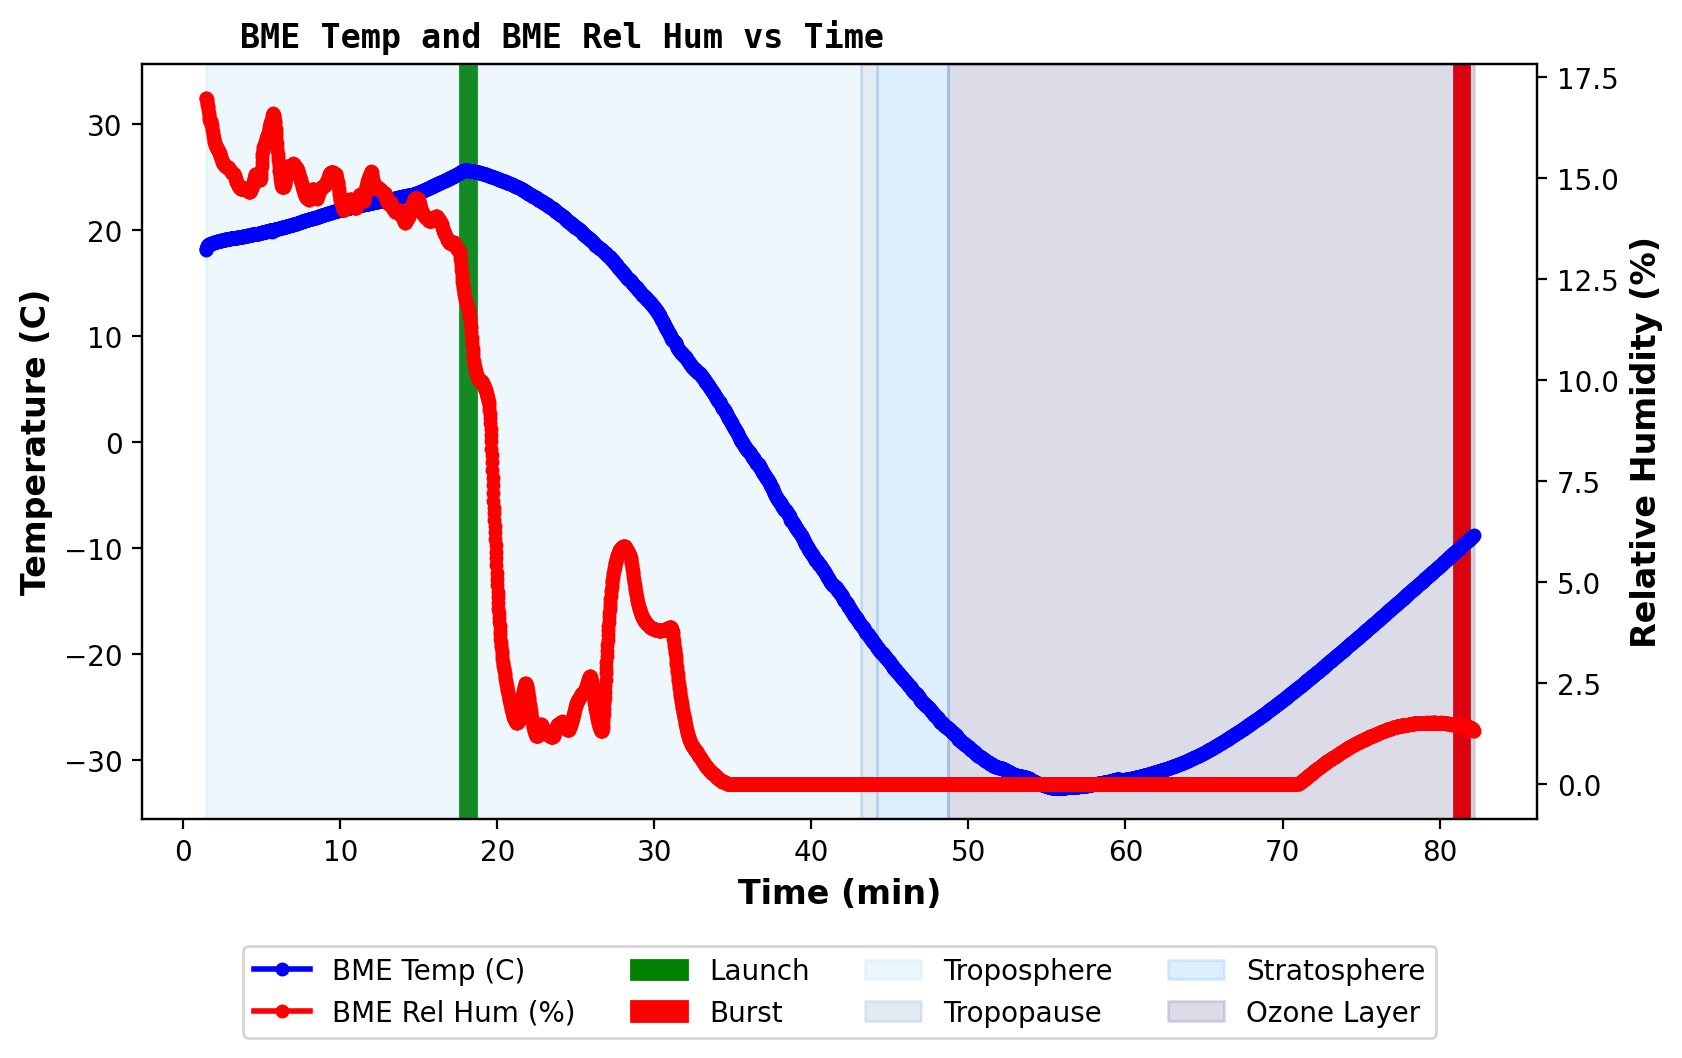

In [14]:
customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Temperature", "C"),
           left_y_cols = [("BMETemp(C)", "BME Temp", "blue")],
           right_y_axis = ("Relative Humidity", "%"), 
           right_y_cols = [("BMEHum(%)", "BME Rel Hum", "red")],
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)


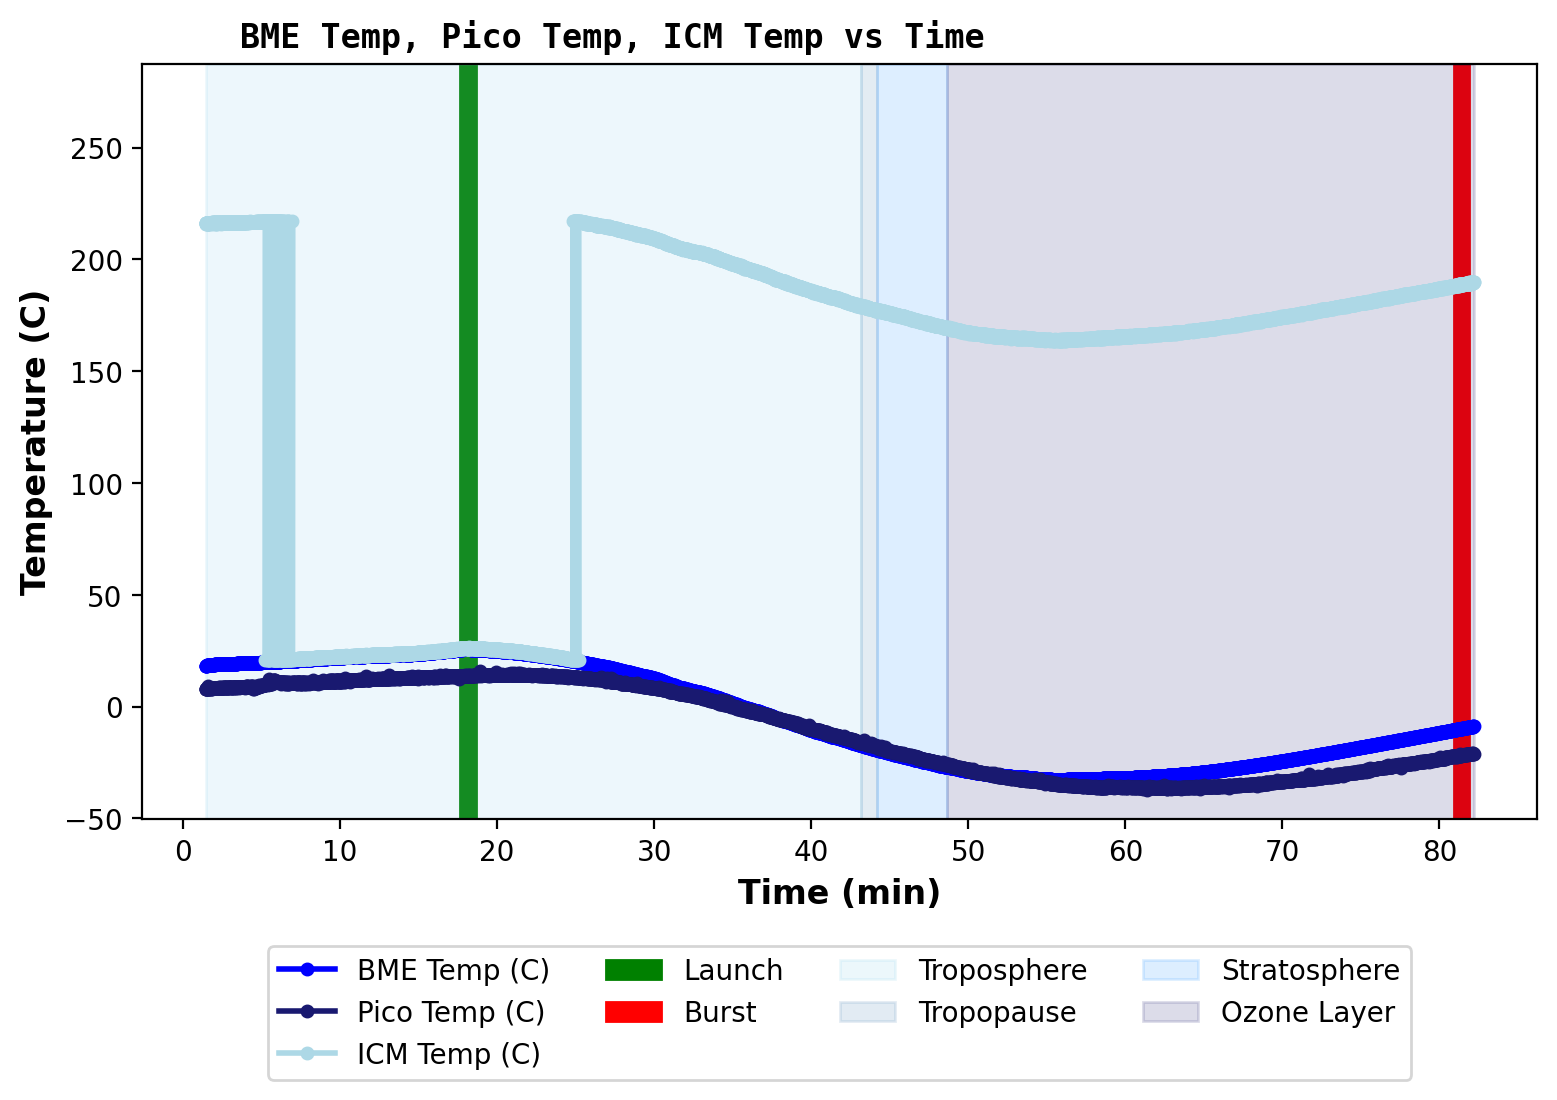

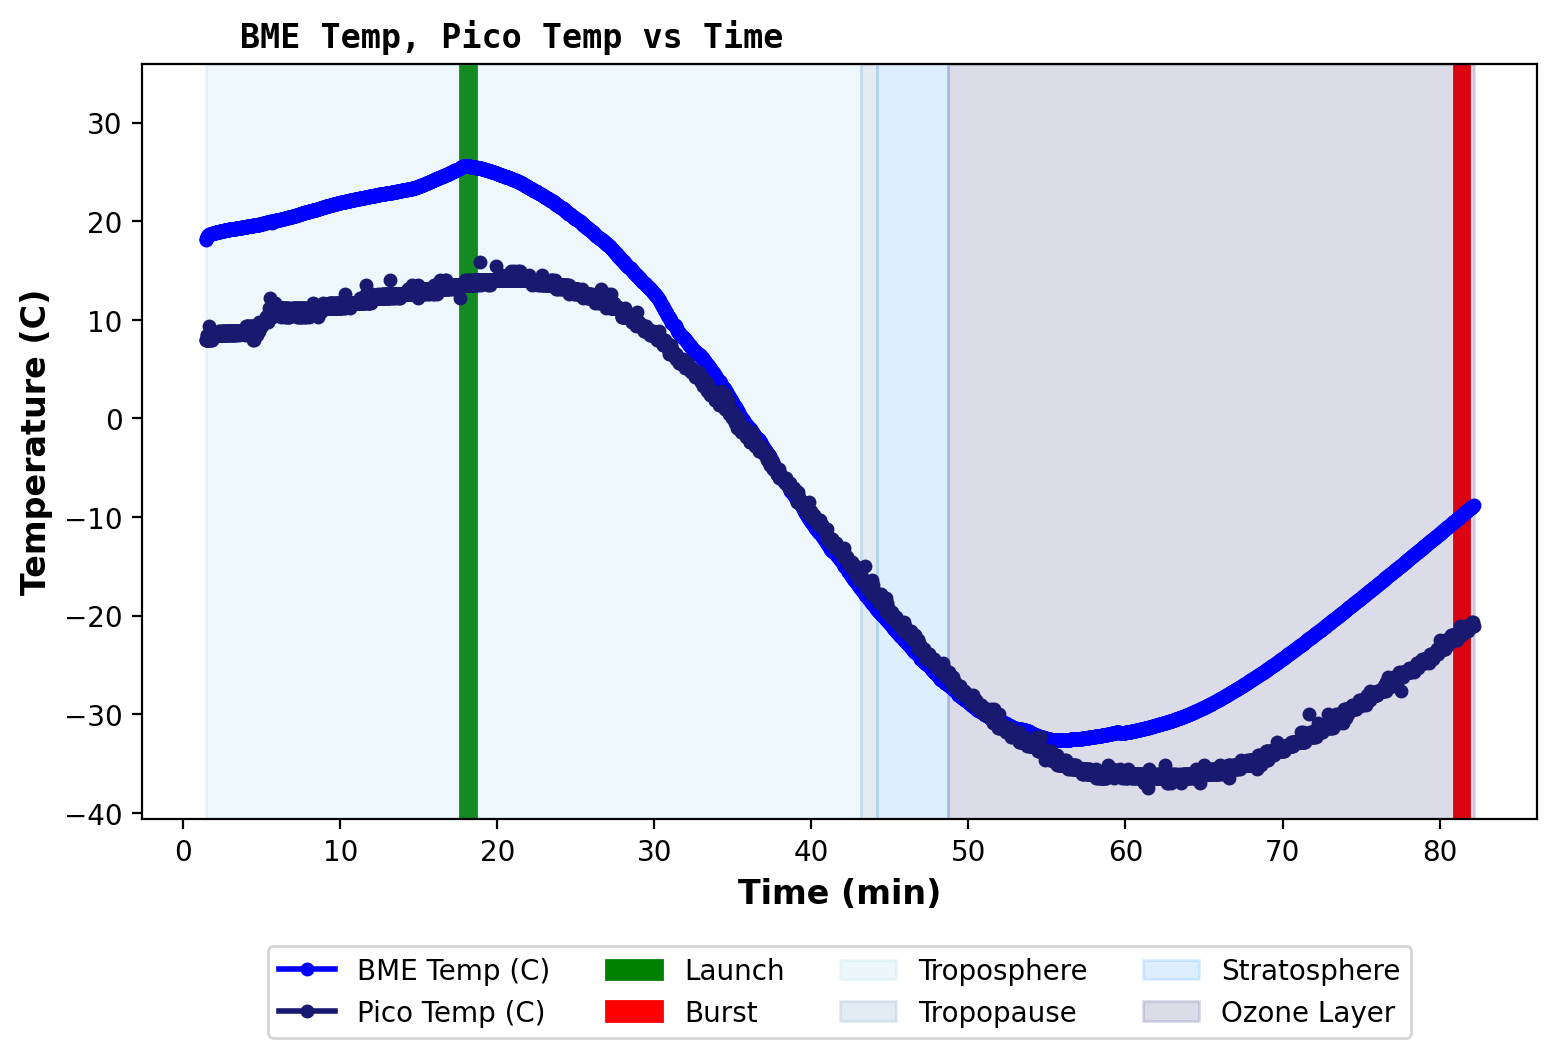

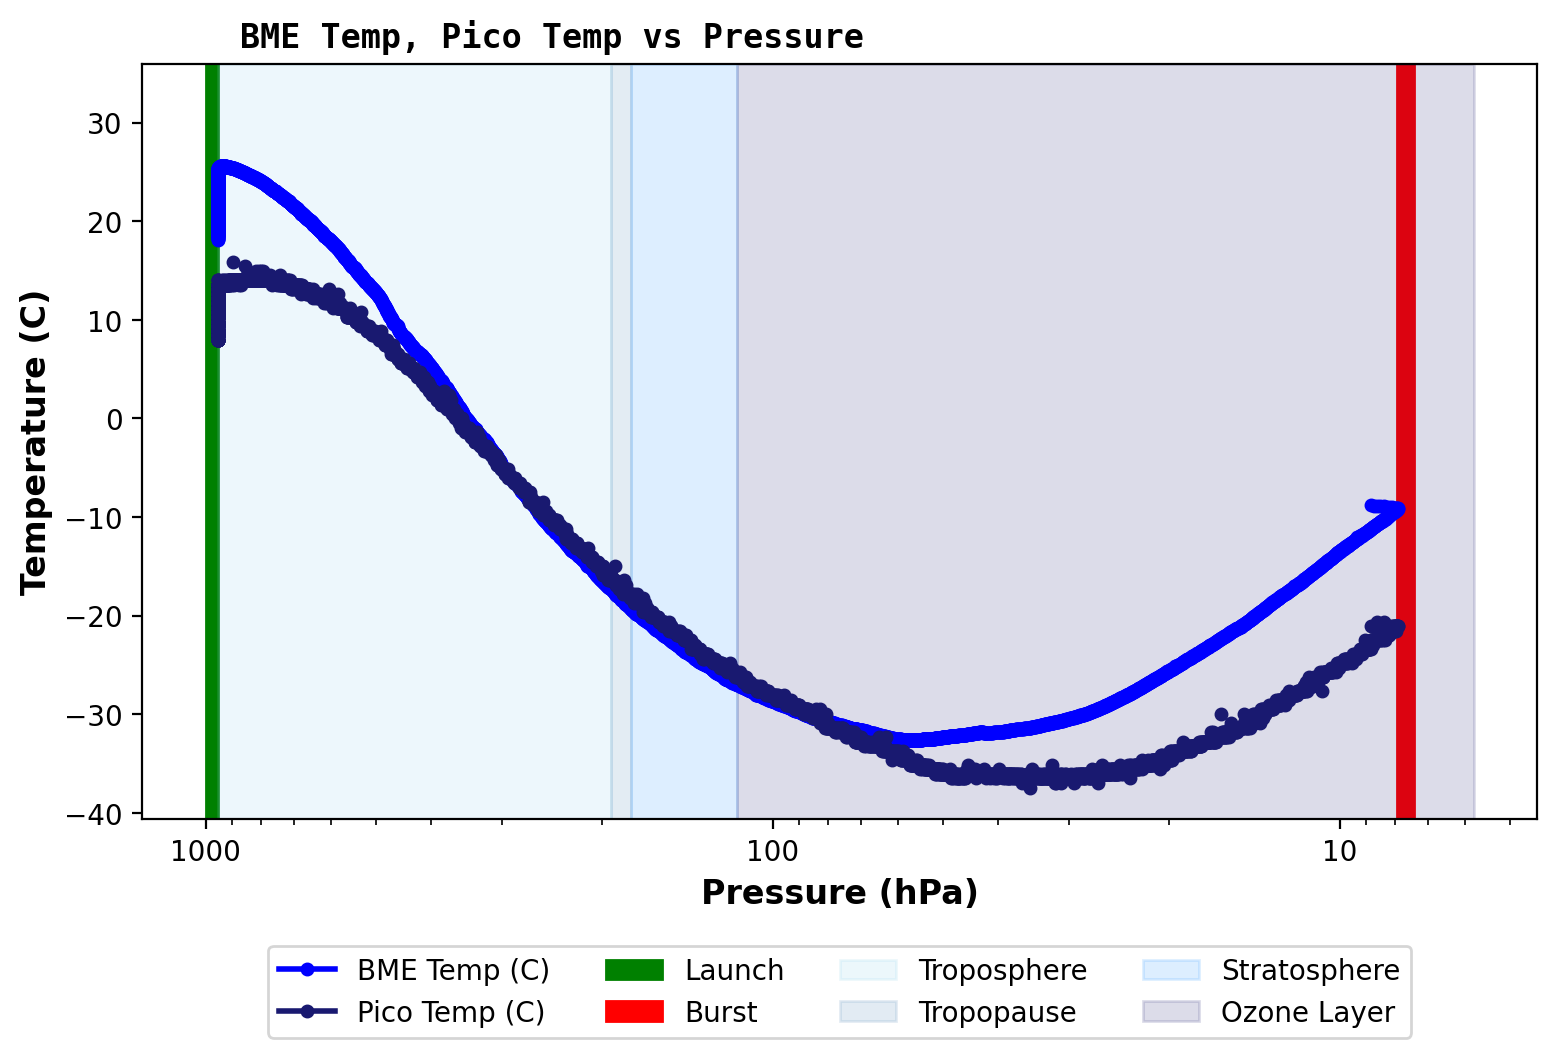

In [15]:
customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Temperature", "C"),
           left_y_cols = [("BMETemp(C)", "BME Temp", "blue"), 
                          ("PicoTemp(C)", "Pico Temp", "midnightblue"),
                          ("ICM TempC", "ICM Temp", "lightblue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)

customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Temperature", "C"),
           left_y_cols = [("BMETemp(C)", "BME Temp", "blue"), 
                          ("PicoTemp(C)", "Pico Temp", "midnightblue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)

customPlot(df = flash_df, 
           x_axis = ("Pressure", "hPa"),
           x_col = "BMEPress(hPa)",
           left_y_axis = ("Temperature", "C"),
           left_y_cols = [("BMETemp(C)", "BME Temp", "blue"), 
                          ("PicoTemp(C)", "Pico Temp", "midnightblue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 2, 
           reverse_and_log = True)



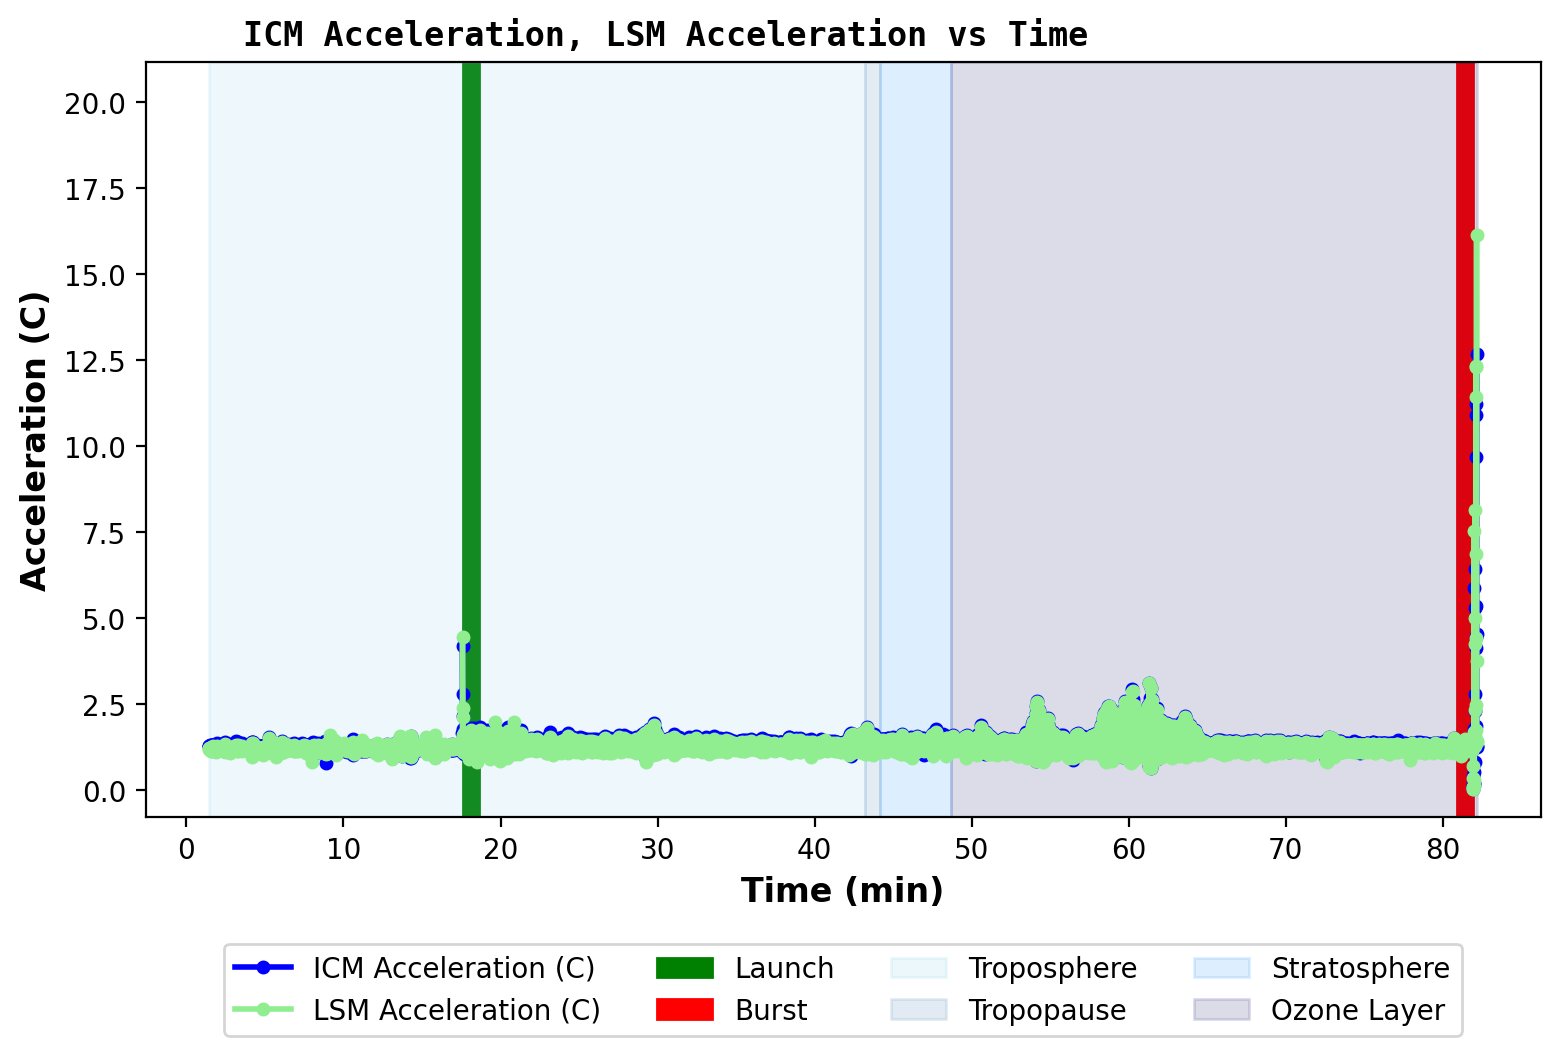

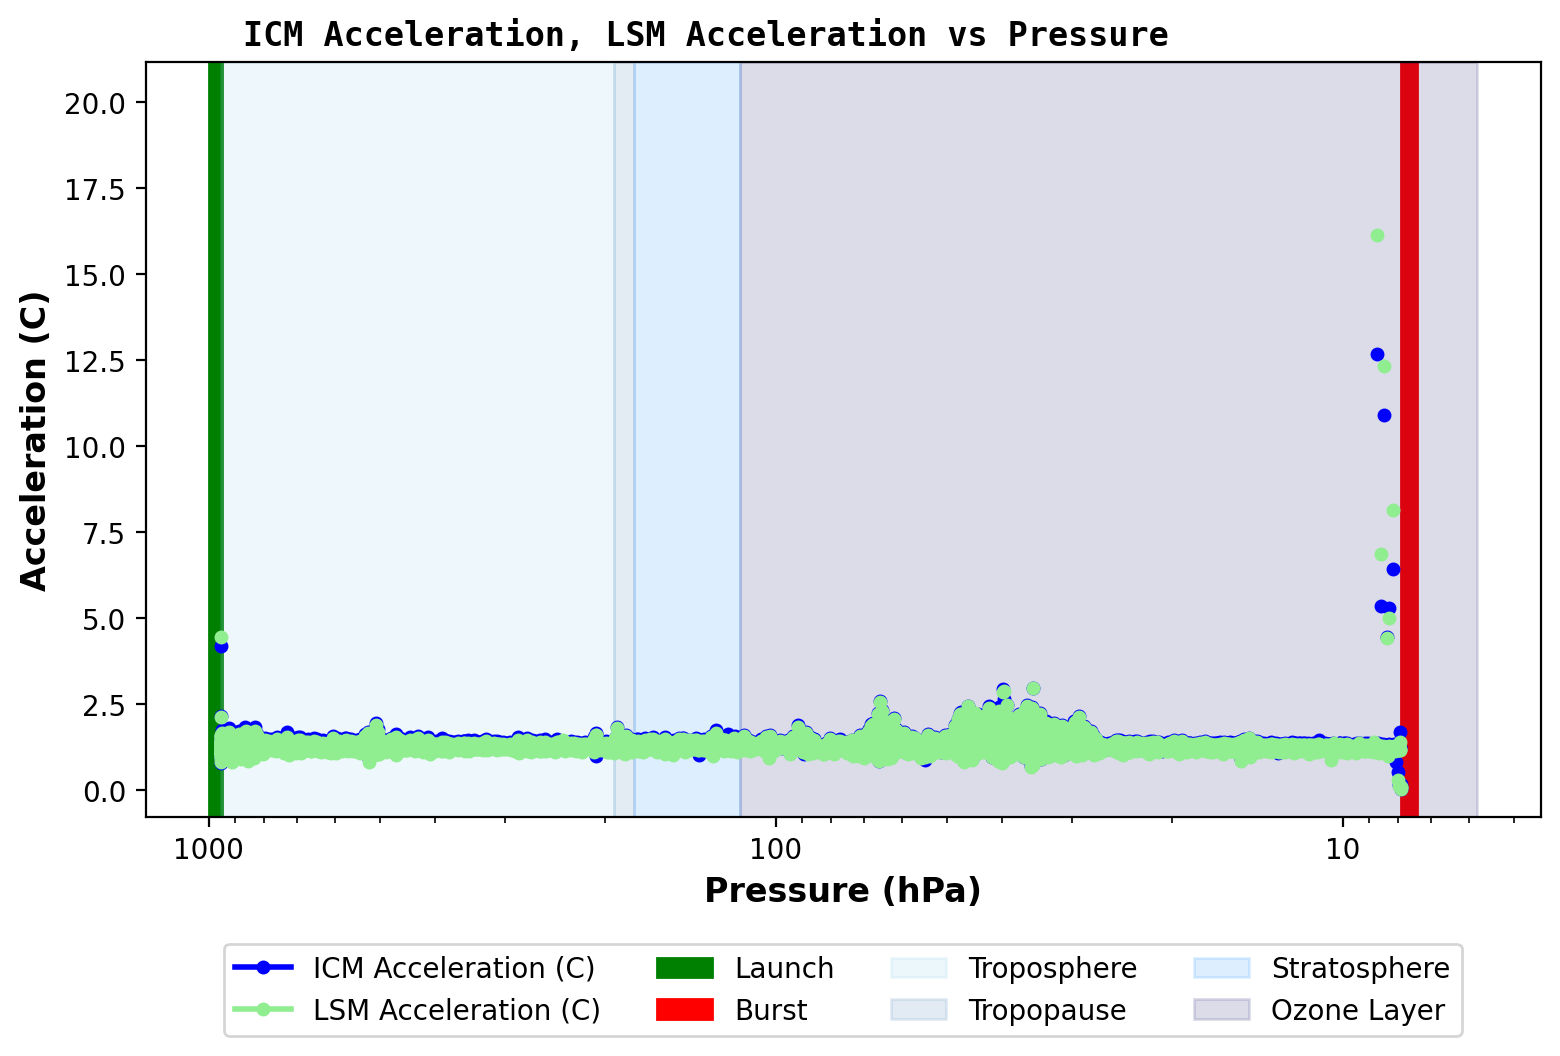

In [16]:
customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Acceleration", "C"),
           left_y_cols = [("ICM Accel Mag", "ICM Acceleration", "blue"), 
                          ("LSM Accel Mag", "LSM Acceleration", "lightgreen")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)

customPlot(df = flash_df, 
           x_axis = ("Pressure", "hPa"),
           x_col = "BMEPress(hPa)",
           left_y_axis = ("Acceleration", "C"),
           left_y_cols = [("ICM Accel Mag", "ICM Acceleration", "blue"), 
                          ("LSM Accel Mag", "LSM Acceleration", "lightgreen")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 2, 
           reverse_and_log = True)

 

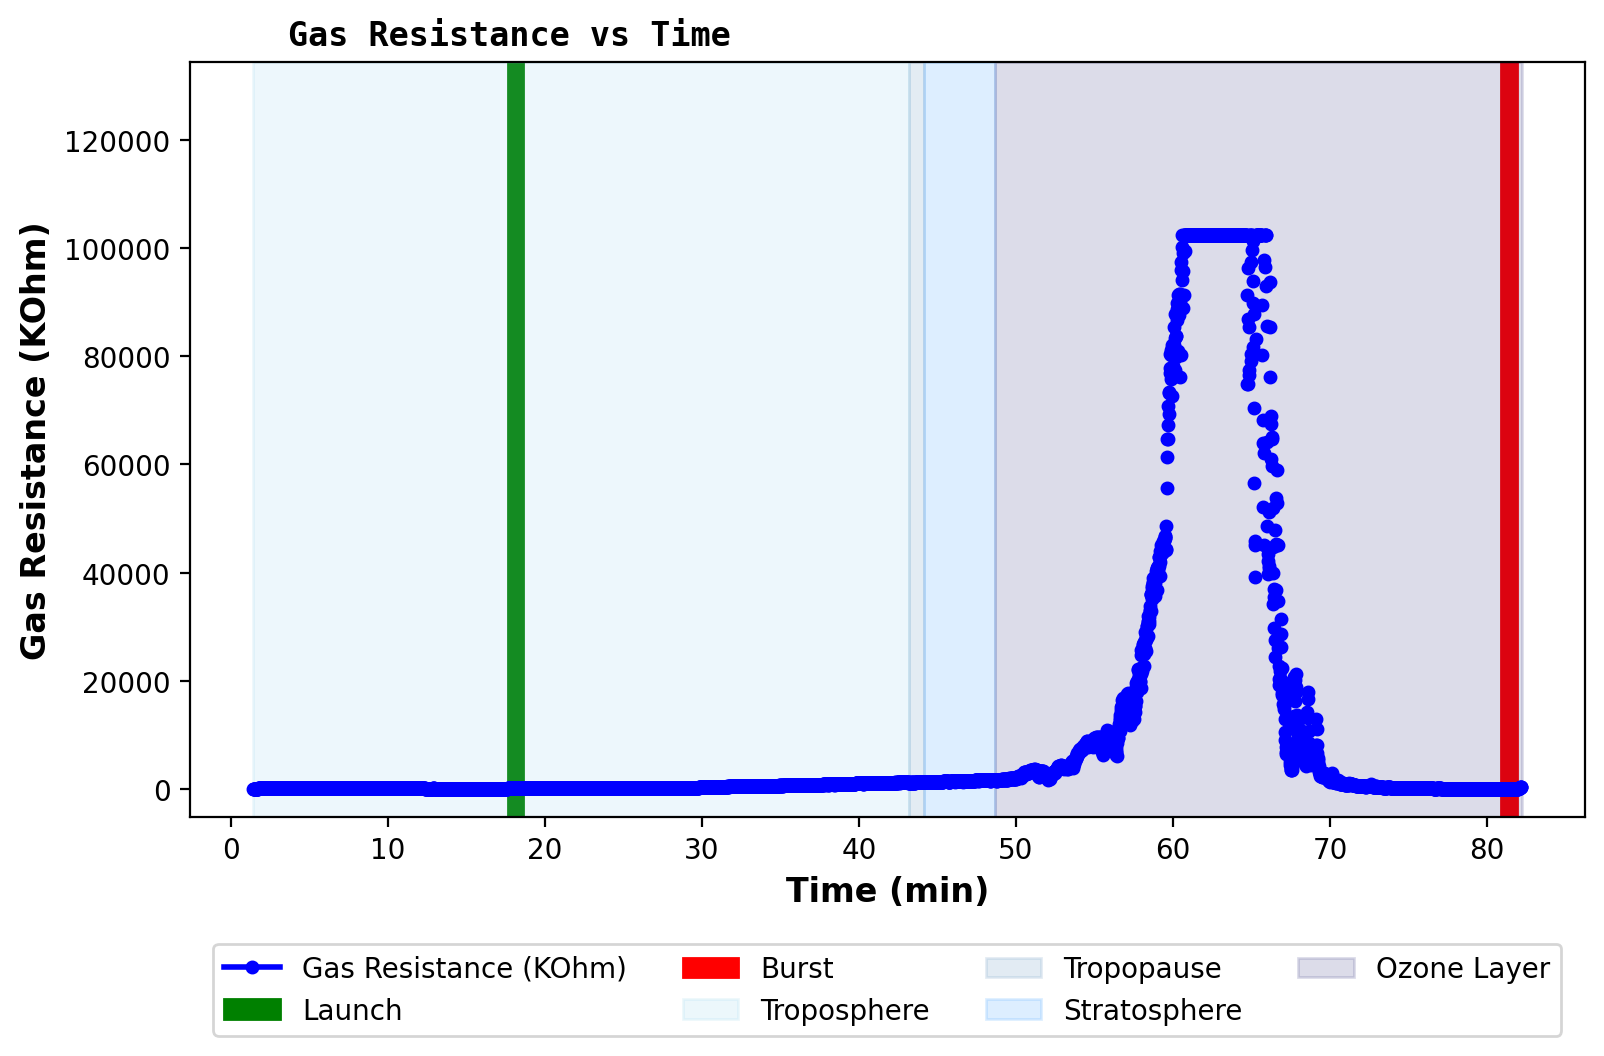

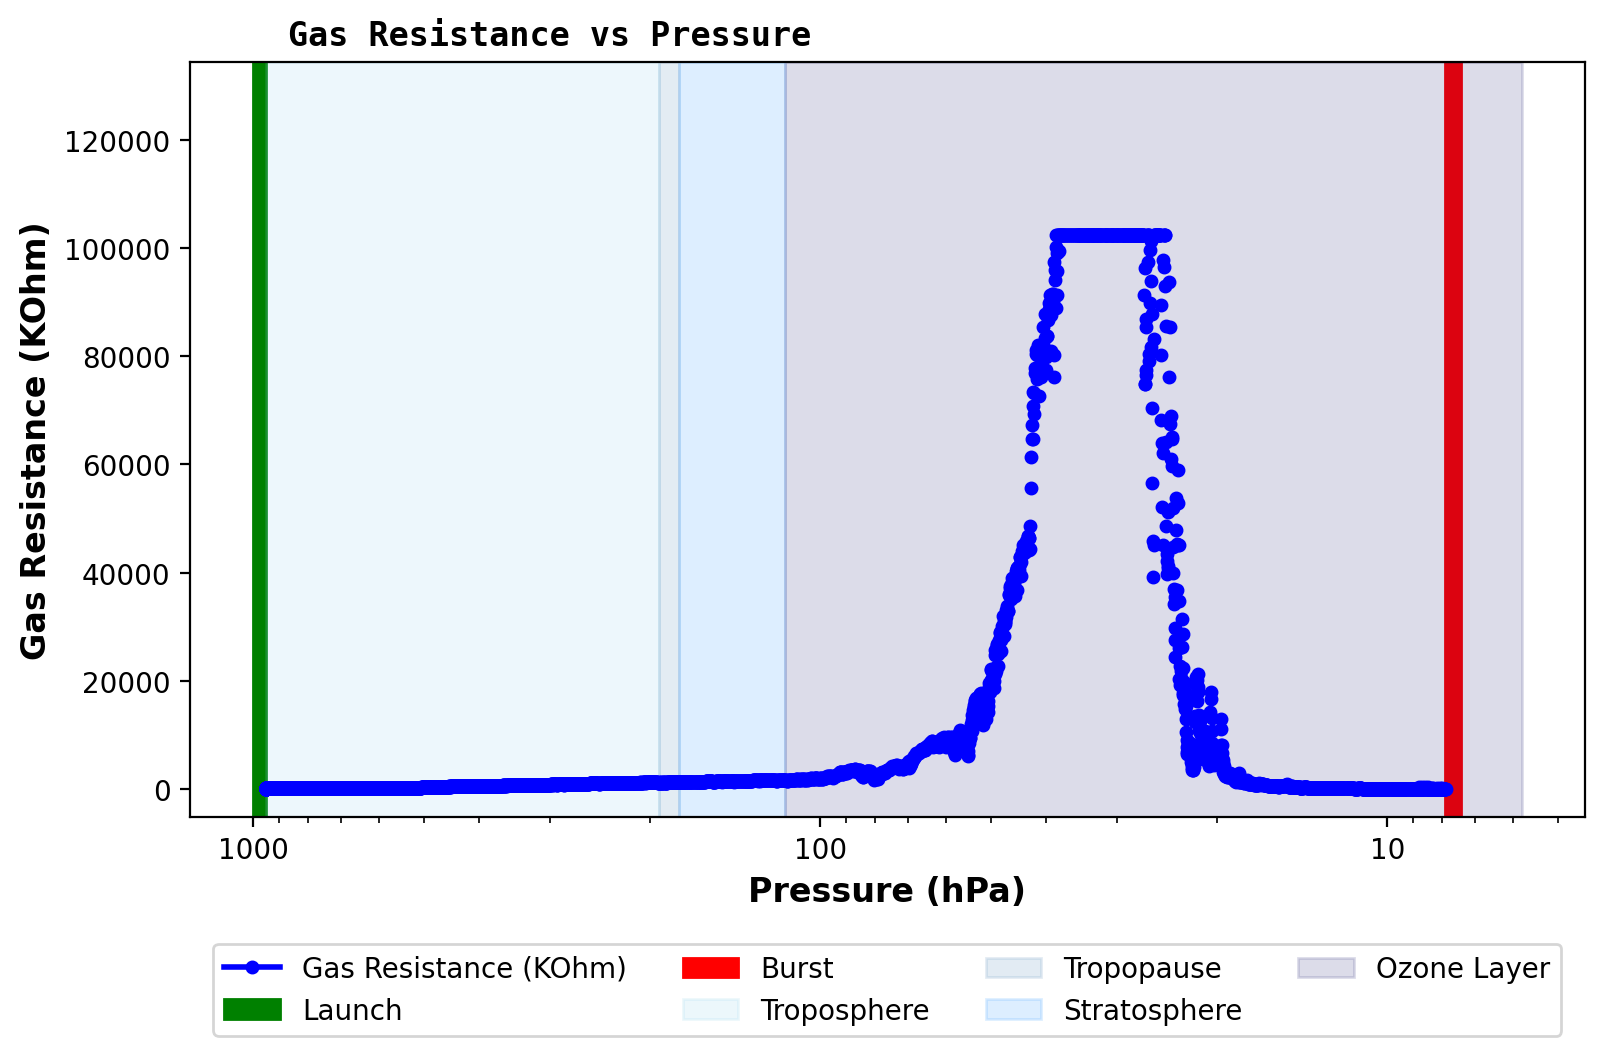

In [17]:
customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Gas Resistance", "KOhm"),
           left_y_cols = [("BMEGas(KOhms)", "Gas Resistance", "blue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)

customPlot(df = flash_df, 
           x_axis = ("Pressure", "hPa"),
           x_col = "BMEPress(hPa)",
           left_y_axis = ("Gas Resistance", "KOhm"),
           left_y_cols = [("BMEGas(KOhms)", "Gas Resistance", "blue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 2, 
           reverse_and_log = True)


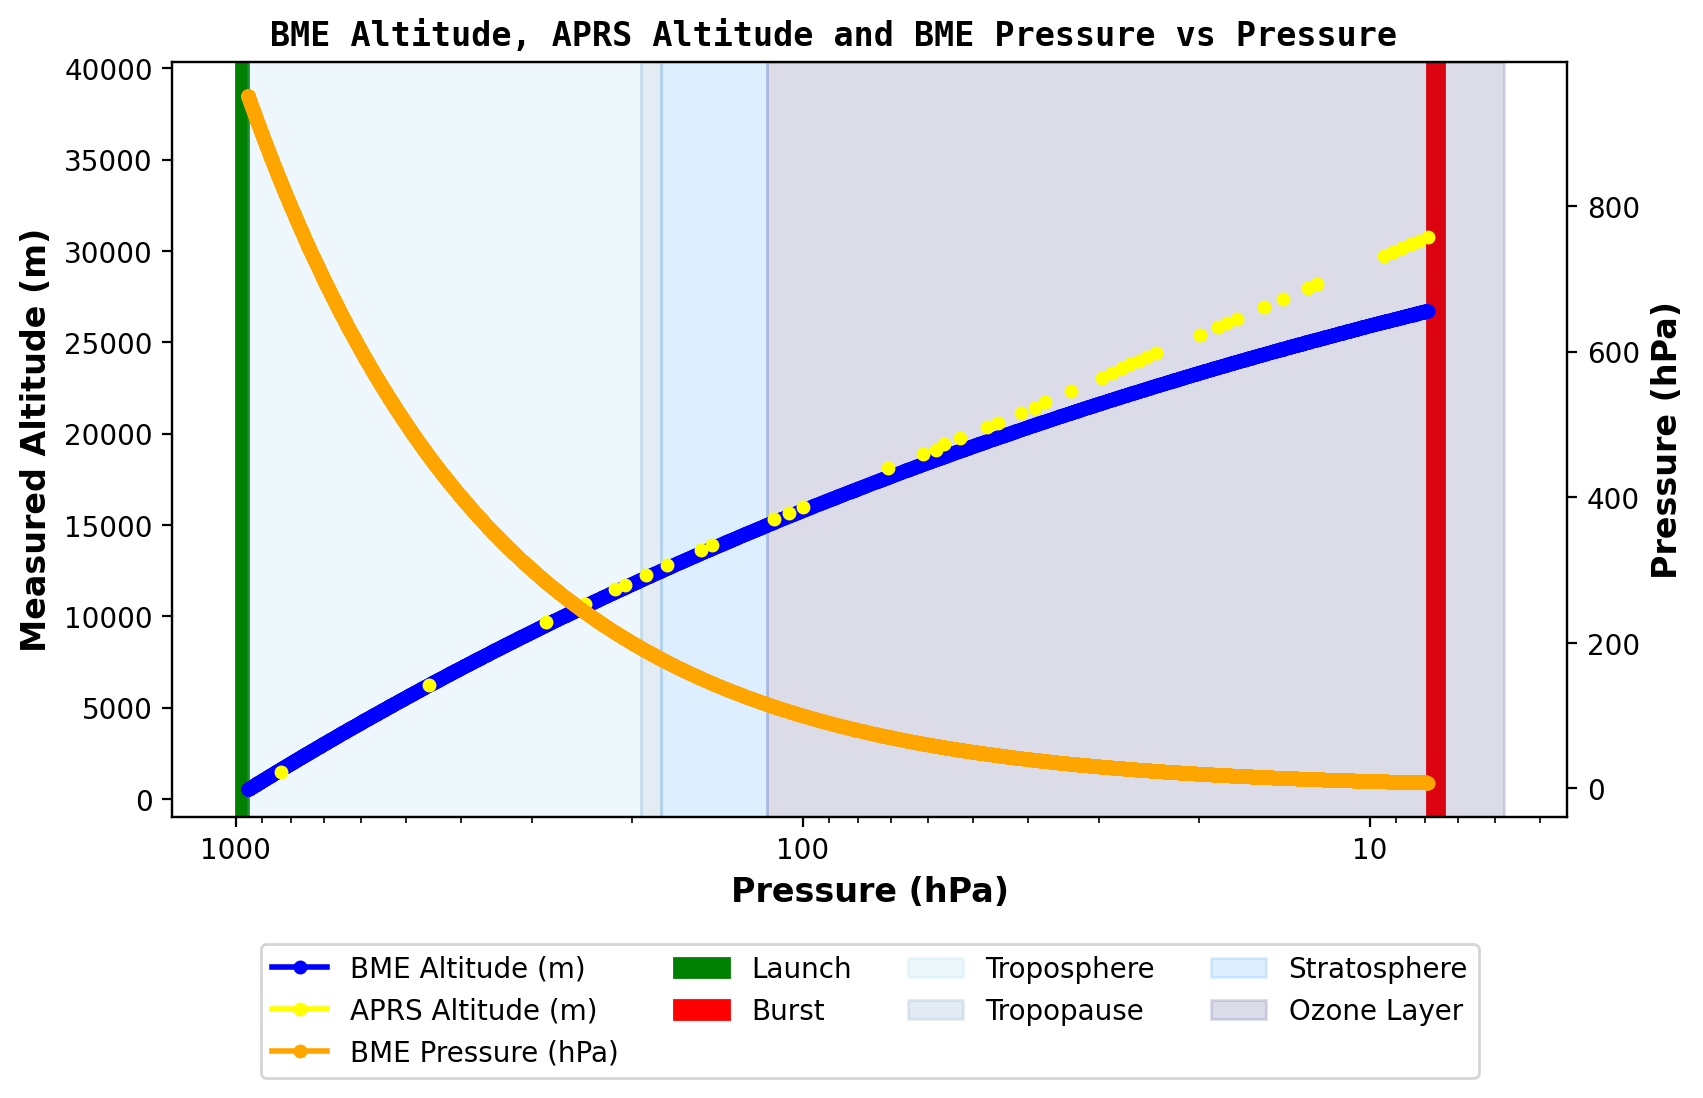

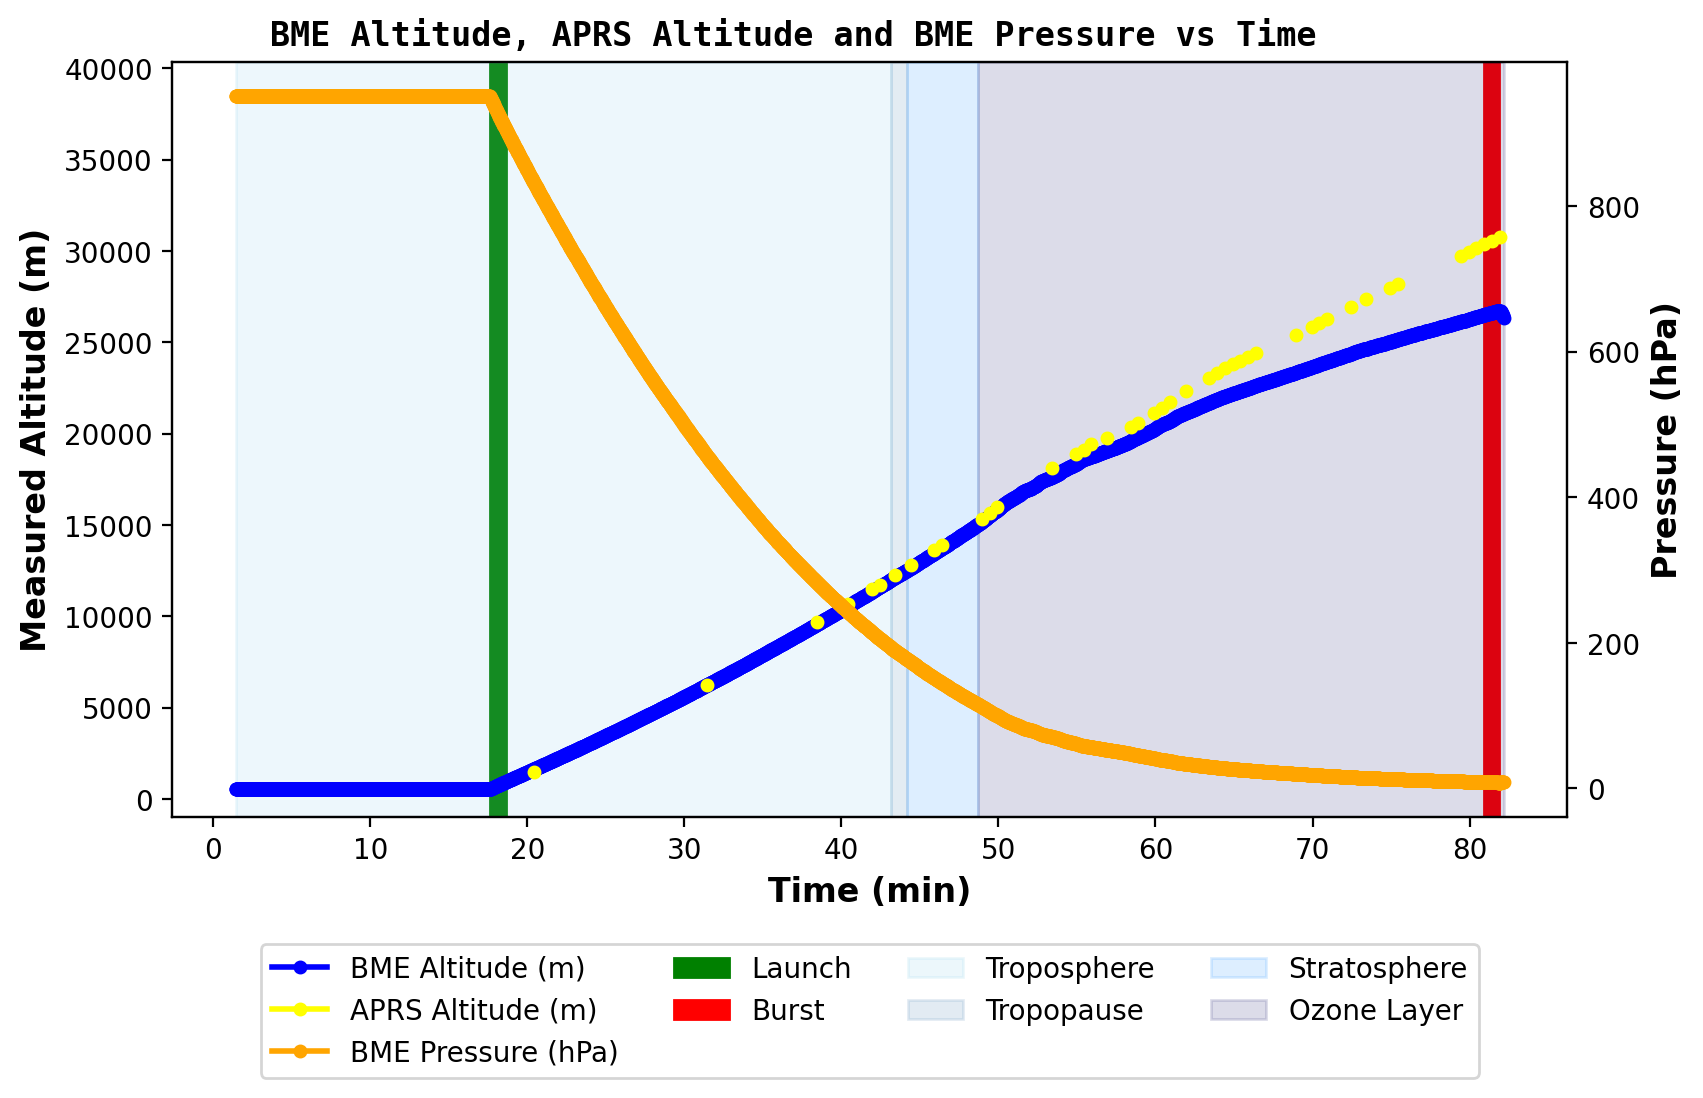

In [18]:
customPlot(df = flash_df, 
           x_axis = ("Pressure", "hPa"),
           x_col = "BMEPress(hPa)",
           left_y_axis = ("Measured Altitude", "m"),
           left_y_cols = [("BMEAlt(m)", "BME Altitude", "blue"),
                          ("aprs altitude", "APRS Altitude", "yellow")],
           right_y_axis = ("Pressure", "hPa"), 
           right_y_cols = [("BMEPress(hPa)", "BME Pressure", "orange")],
           fills = shaders, 
           fills_index_offset = 2, 
           reverse_and_log = True)

customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Measured Altitude", "m"),
           left_y_cols = [("BMEAlt(m)", "BME Altitude", "blue"),
                          ("aprs altitude", "APRS Altitude", "yellow")],
           right_y_axis = ("Pressure", "hPa"), 
           right_y_cols = [("BMEPress(hPa)", "BME Pressure", "orange")],
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)

# MetPy

In [19]:
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

13	13	13	13	13
Speed	Course	Pres	Temp	Rel Hum
11.88	59.0	831.55	24.57	0.028
43.74	69.0	456.51	8.92	0.0283
43.2	96.0	283.08	-6.62	0.0
54.0	90.0	242.53	-11.43	0.0
77.21	91.0	214.64	-14.45	0.0
70.73	100.0	205.63	-15.66	0.0
80.99	90.0	188.64	-17.91	0.0
92.87	104.0	173.61	-19.85	0.0
57.78	103.0	151.3	-22.49	0.0
70.73	106.0	144.47	-23.39	0.0
69.11	85.0	112.36	-27.33	0.0
70.73	94.0	105.66	-28.1	0.0
64.25	103.0	99.69	-28.72	0.0


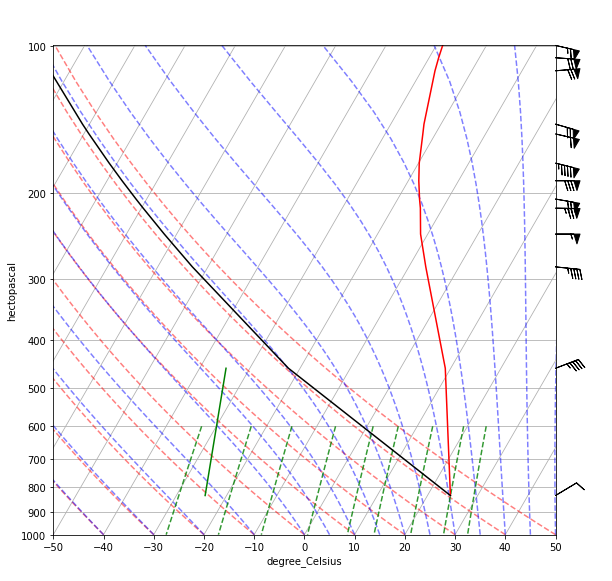

In [30]:
wind_speed = []
course = []
pres = []
temp = []
rel_hum = [] 

last_pres = 10000
for i in range(len(flash_df["Millis"])):
    # need a speed measure
    if str(flash_df["aprs speed"][i]) == "nan": continue
    
    wind_speed.append(flash_df["aprs speed"][i] * 0.5399568) # k/h knots
    course.append(flash_df["aprs course"][i]) # degrees from north 
    next_bme_index = i
    while str(flash_df["BMEPress(hPa)"][next_bme_index]) == "nan": next_bme_index += 1
    pres.append(flash_df["BMEPress(hPa)"][next_bme_index])
    temp.append(flash_df["BMETemp(C)"][next_bme_index])
    rel_hum.append(flash_df["BMEHum(%)"][next_bme_index] / 100.0)
    
    if(pres[-1] < 100): break
    
 
print(len(wind_speed), len(course), len(pres), len(temp), len(rel_hum), sep="\t")
print("Speed", "Course", "Pres", "Temp", "Rel Hum", sep="\t")
for i in range(len(wind_speed)):
    print(round(wind_speed[i], 2), course[i], pres[i], temp[i], round(rel_hum[i], 4), sep="\t")


# skewT
fig = plt.figure(figsize = (9,9))
skew = SkewT(fig=fig, aspect='auto')

pres = np.array(pres) * units.hPa
temp = np.array(temp) * units.degC
rel_hum = np.array(rel_hum) * units.dimensionless
dewpoint = mpcalc.dewpoint_from_relative_humidity(temperature=temp, relative_humidity=rel_hum)

prof = mpcalc.parcel_profile(pres, temp[0], dewpoint[0]).to('degC')

# # fix with aprs data 
# u = wind_speed * units.knots
# v = np.linspace(-20, 20, len(pres)) * units.knots

wind_speed = np.array(wind_speed) * units.knots
course = np.array(course) * units.deg

u, v = mpcalc.wind_components(wind_speed, course)
# u = np.linspace(-10, 10, len(pres)) * units.knots
# v = np.linspace(-20, 20, len(pres)) * units.knots

skew.plot(pres, temp, 'r')
skew.plot(pres, dewpoint, 'g')
skew.plot(pres, prof, 'k')
skew.plot_barbs(pres[::1], u[::1], v[::1])

skew.ax.set_xlim(-50, 50)
skew.ax.set_ylim(1000, min(pres))

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

plt.savefig(os.path.join(graph_folder, f"skewTLogP.svg"))
plt.savefig(os.path.join(graph_folder, f"skewTLogP.png"))

plt.show()

# APRS

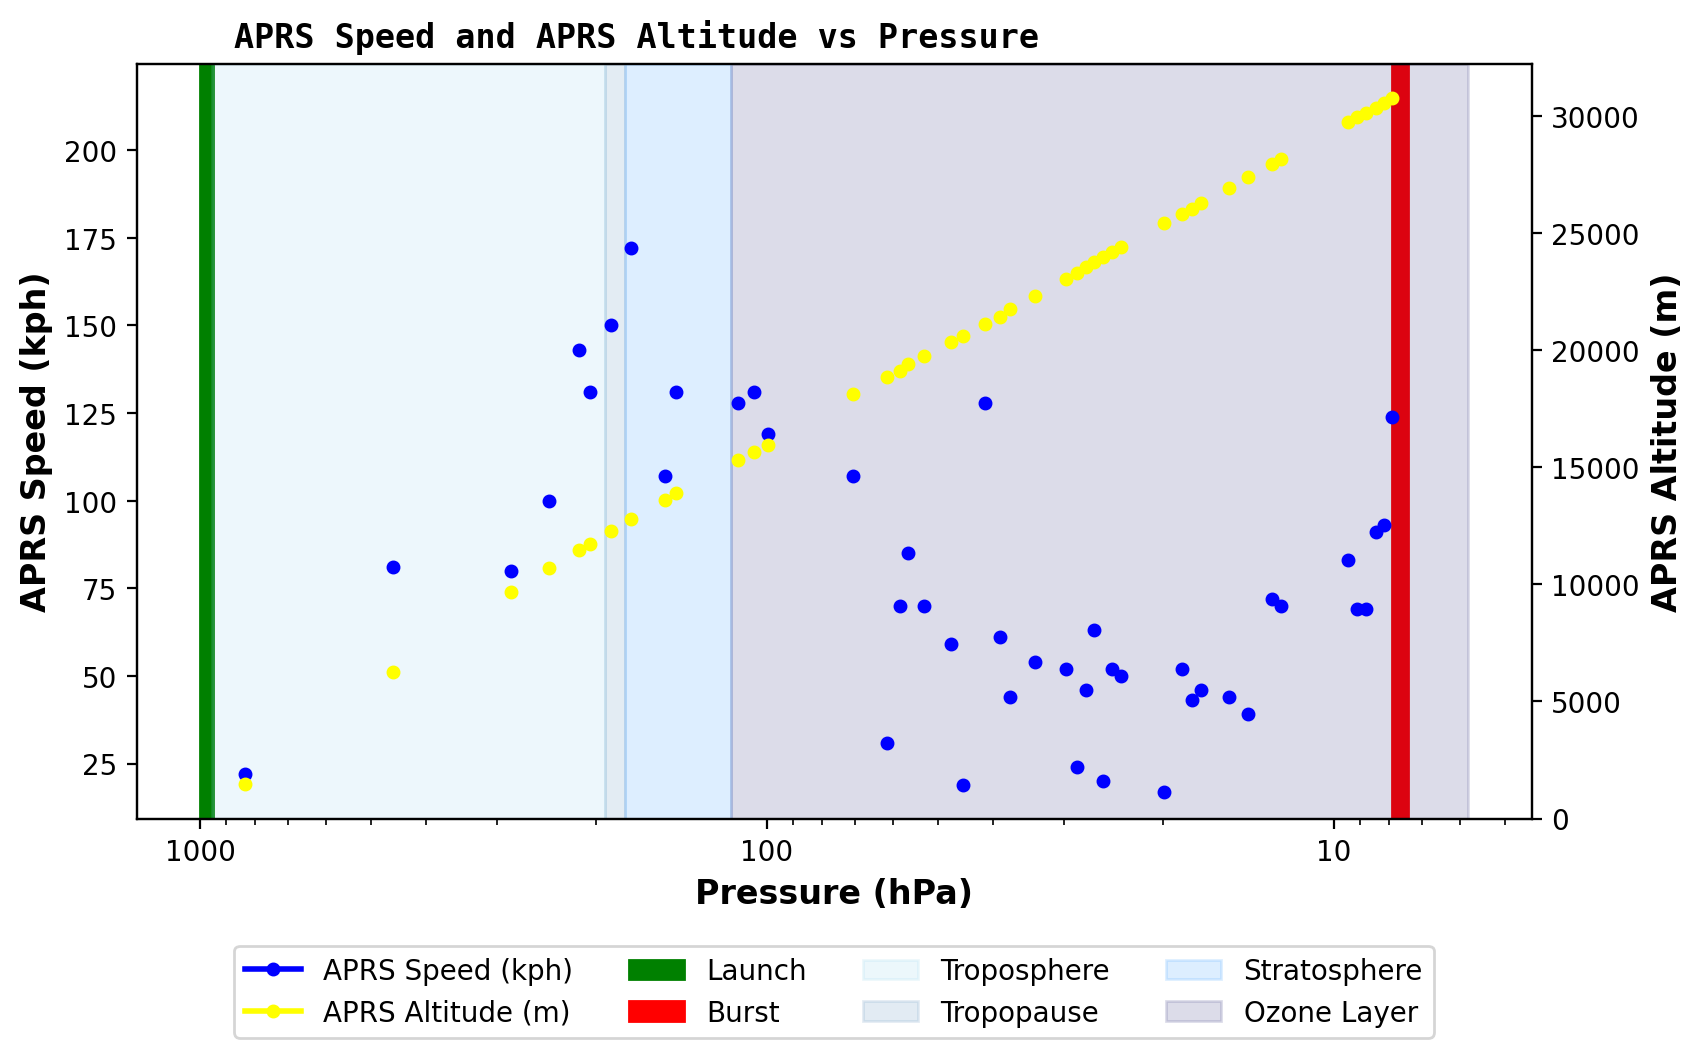

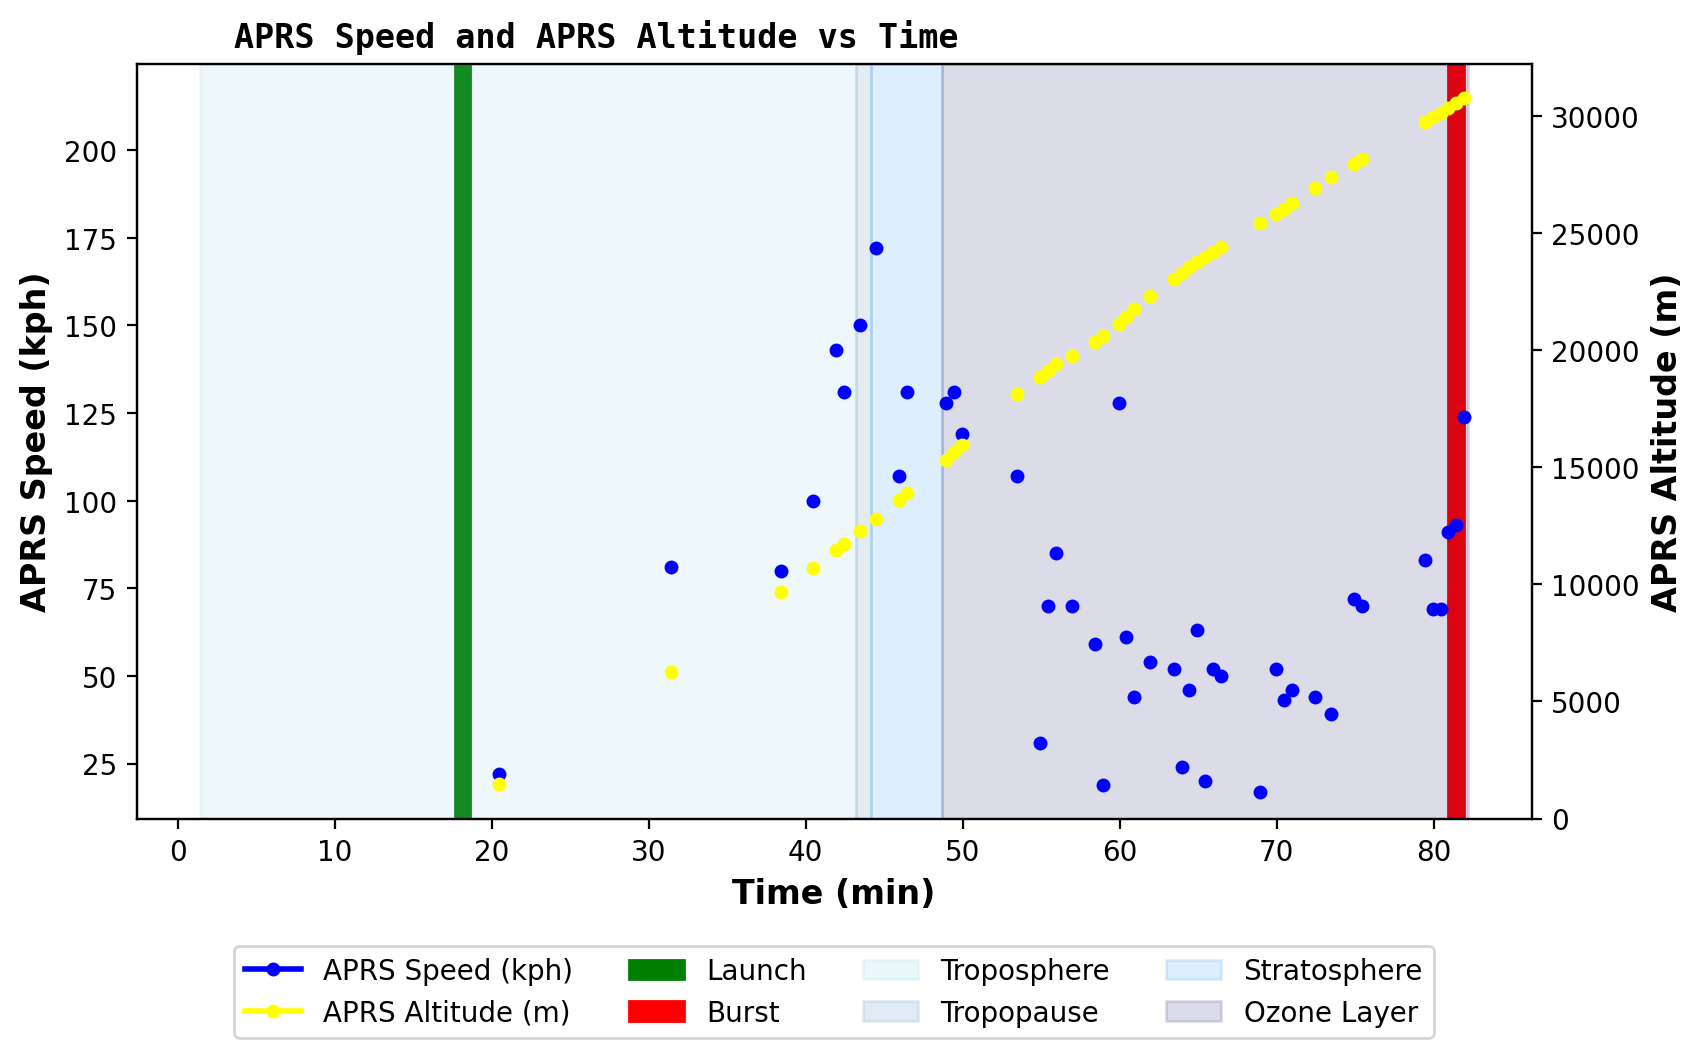

In [21]:
customPlot(df = flash_df, 
           x_axis = ("Pressure", "hPa"),
           x_col = "BMEPress(hPa)",
           left_y_axis = ("APRS Speed", "kph"),
           left_y_cols = [("aprs speed", "APRS Speed", "blue")],
           right_y_axis = ("APRS Altitude", "m"), 
           right_y_cols = [("aprs altitude", "APRS Altitude", "yellow")],
           fills = shaders, 
           fills_index_offset = 2, 
           reverse_and_log = True)

customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("APRS Speed", "kph"),
           left_y_cols = [("aprs speed", "APRS Speed", "blue")],
           right_y_axis = ("APRS Altitude", "m"), 
           right_y_cols = [("aprs altitude", "APRS Altitude", "yellow")],
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)

# RadiaCode 102 Geiger Counter

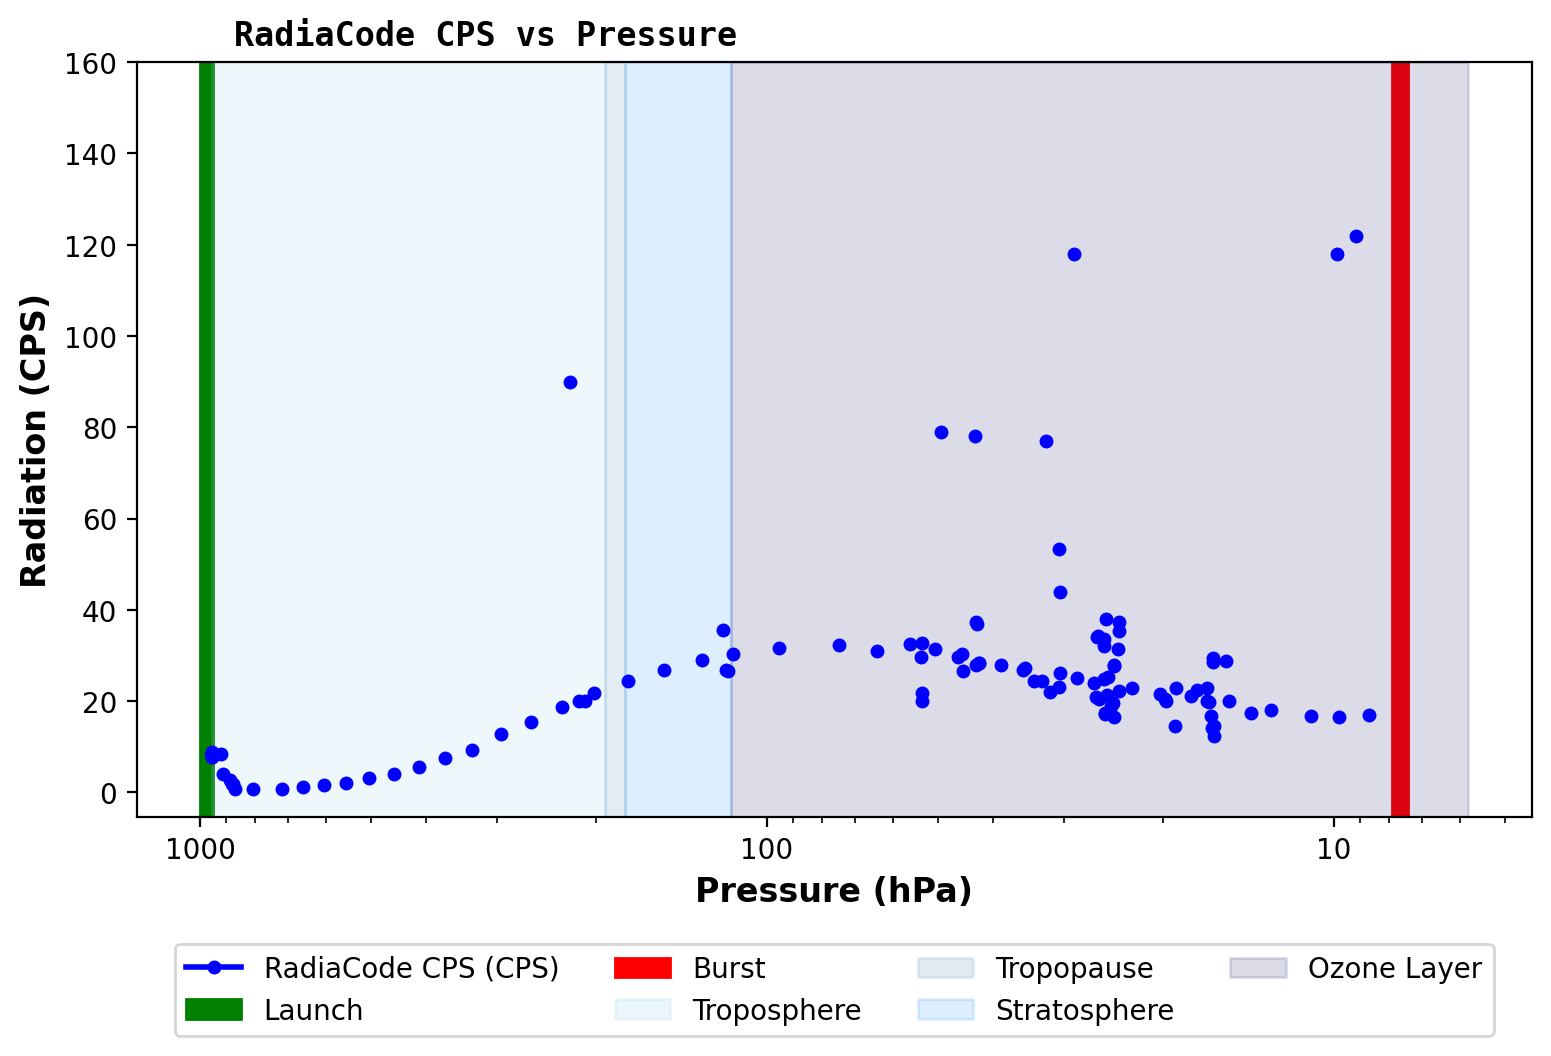

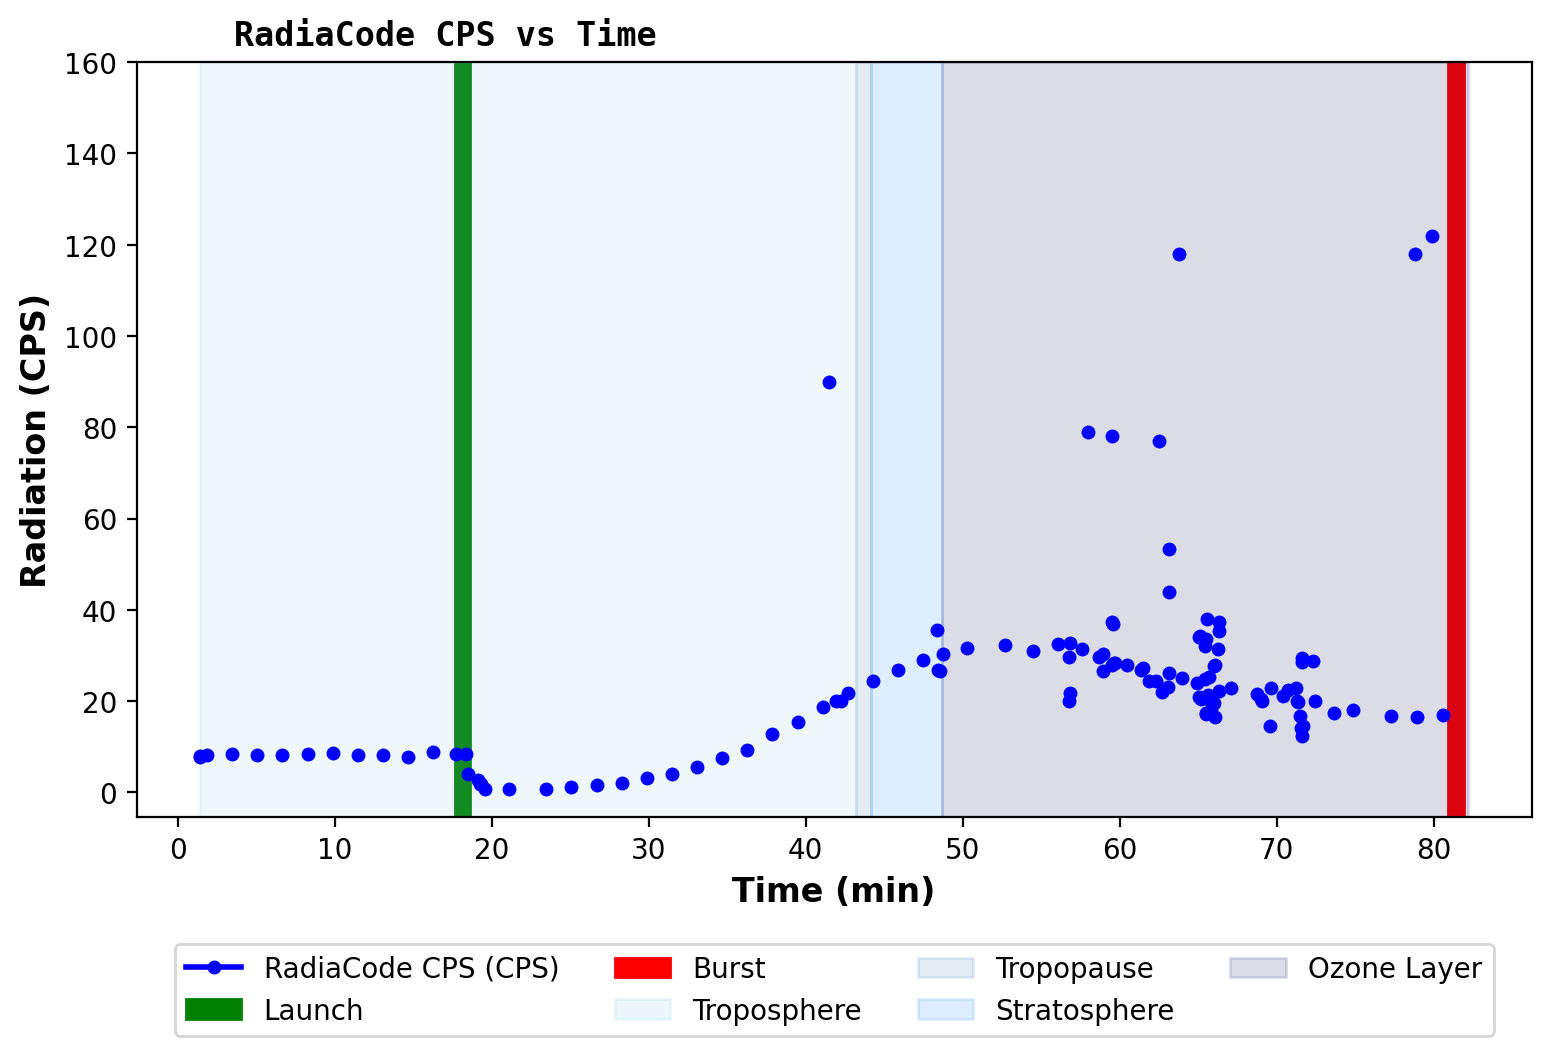

In [22]:
# cps
customPlot(df = flash_df, 
           x_axis = ("Pressure", "hPa"),
           x_col = "BMEPress(hPa)",
           left_y_axis = ("Radiation", "CPS"),
           left_y_cols = [("geiger cps", "RadiaCode CPS", "blue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 2, 
           reverse_and_log = True)

customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Radiation", "CPS"),
           left_y_cols = [("geiger cps", "RadiaCode CPS", "blue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)

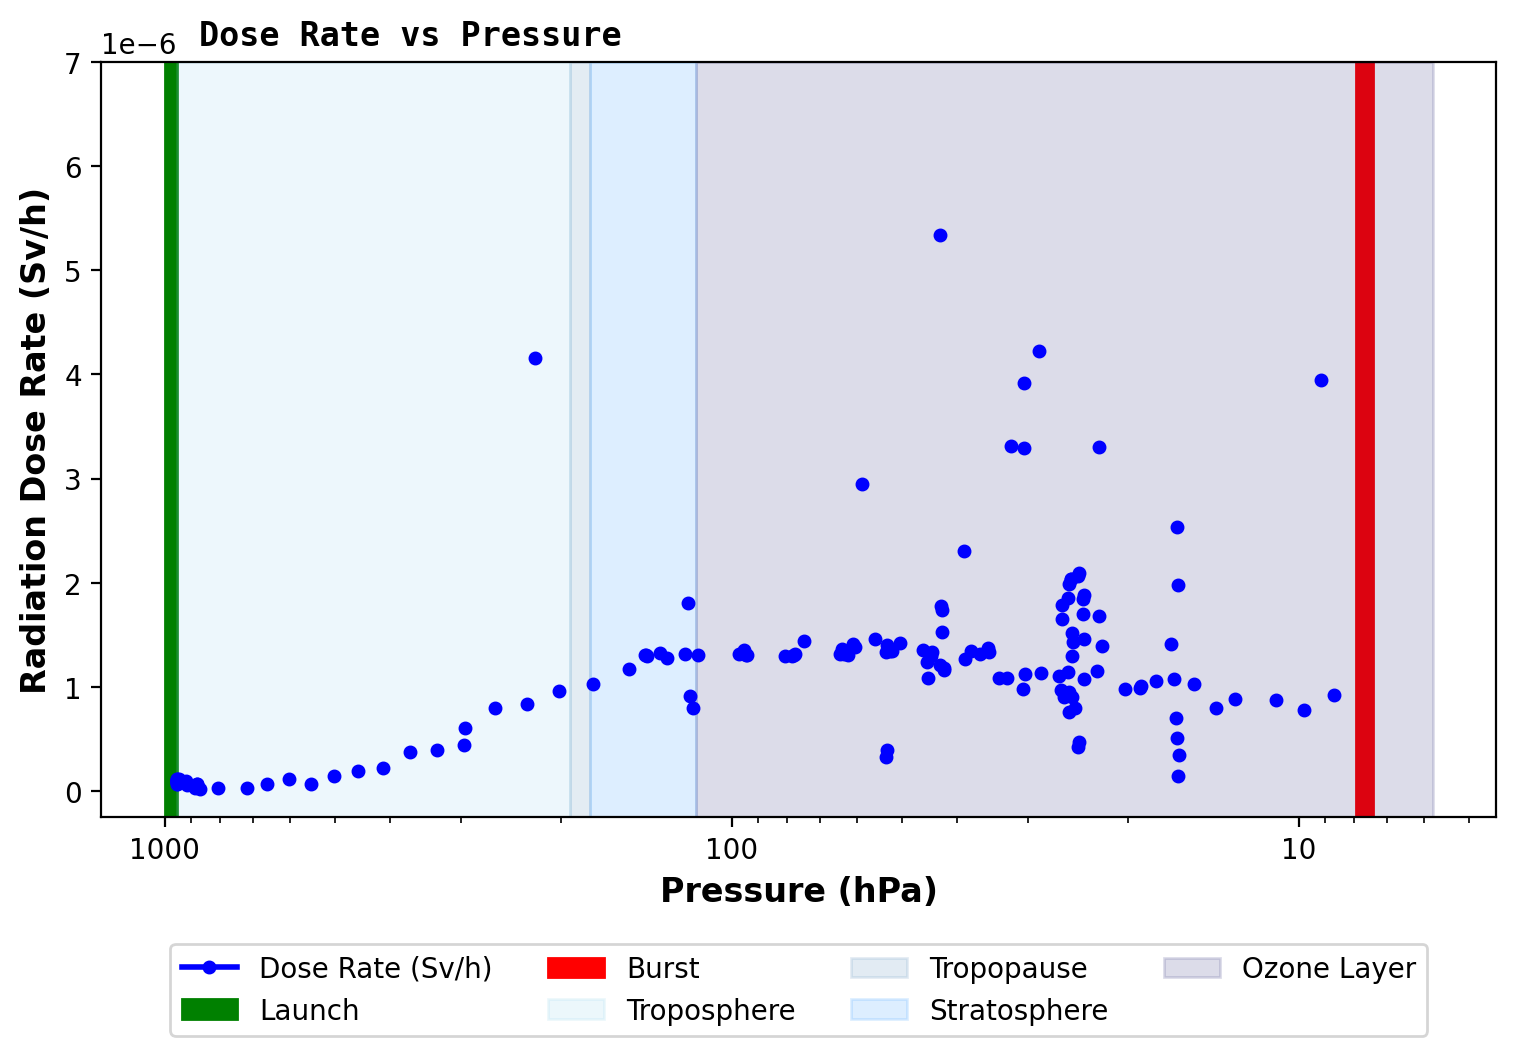

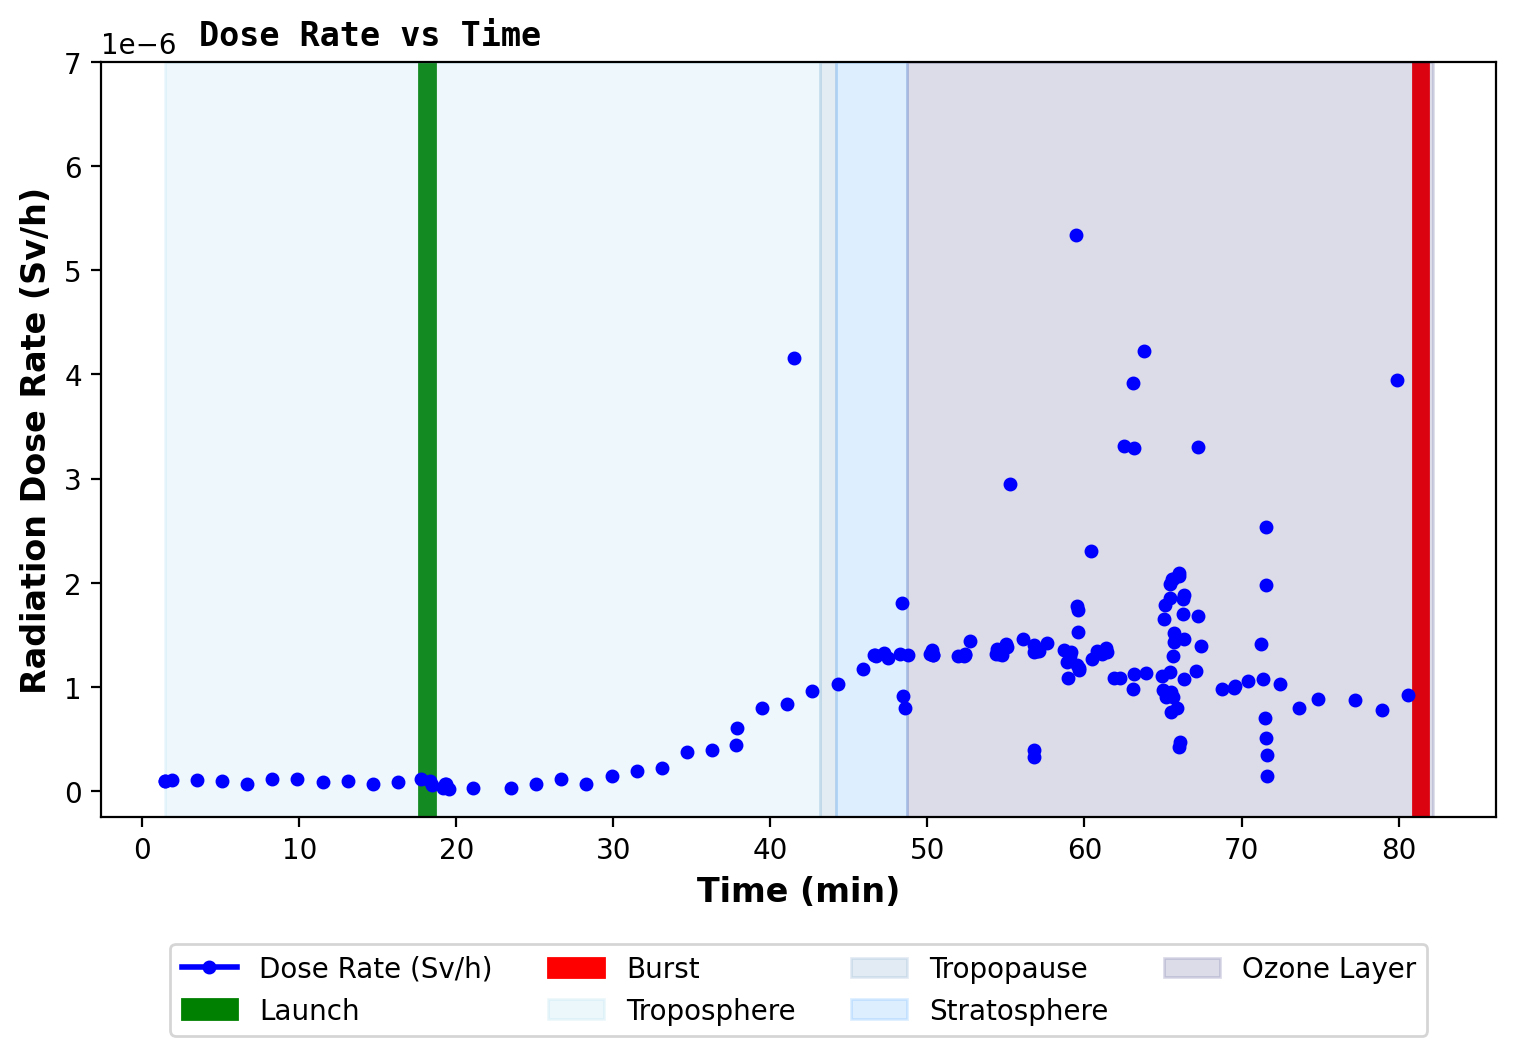

In [23]:
# dose rate
customPlot(df = flash_df, 
           x_axis = ("Pressure", "hPa"),
           x_col = "BMEPress(hPa)",
           left_y_axis = ("Radiation Dose Rate", "Sv/h"),
           left_y_cols = [("geiger dose rate Sv/h", "Dose Rate", "blue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 2, 
           reverse_and_log = True)

customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Radiation Dose Rate", "Sv/h"),
           left_y_cols = [("geiger dose rate Sv/h", "Dose Rate", "blue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)

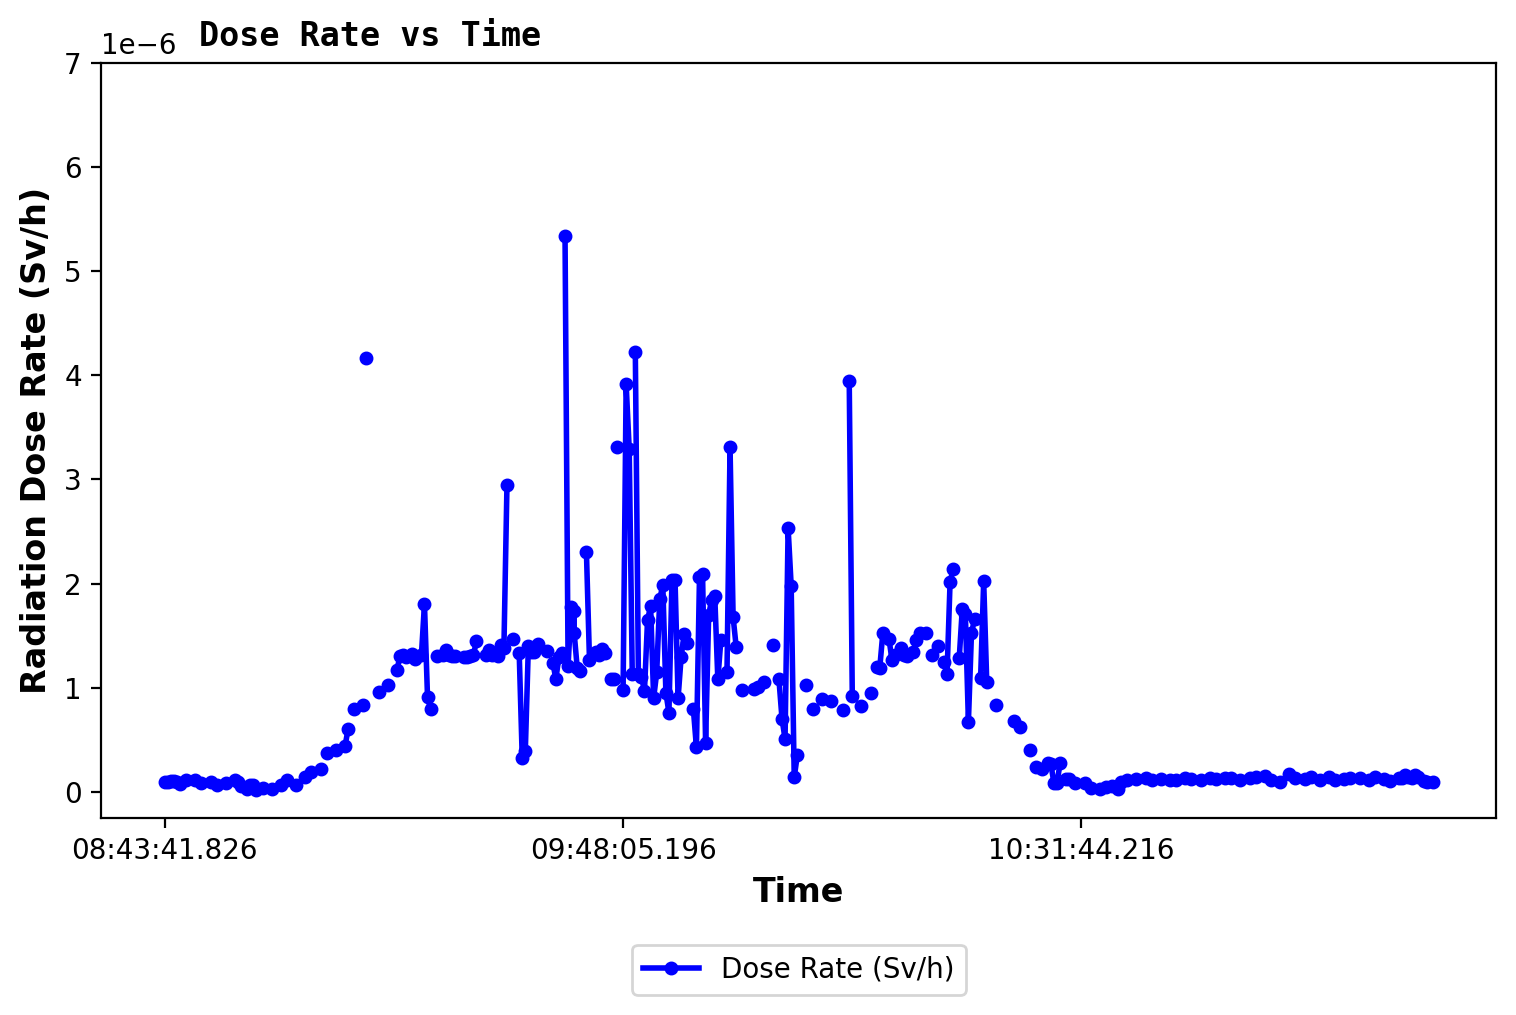

In [24]:
customPlot(df = geiger_df, 
           x_axis = ("Time", ""),
           x_col = "Just Time",
           left_y_axis = ("Radiation Dose Rate", "Sv/h"),
           left_y_cols = [("Dose rate: Sv/h", "Dose Rate", "blue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = None, 
           fills_index_offset = None, 
           reverse_and_log = False,
           x_ticks = 4)

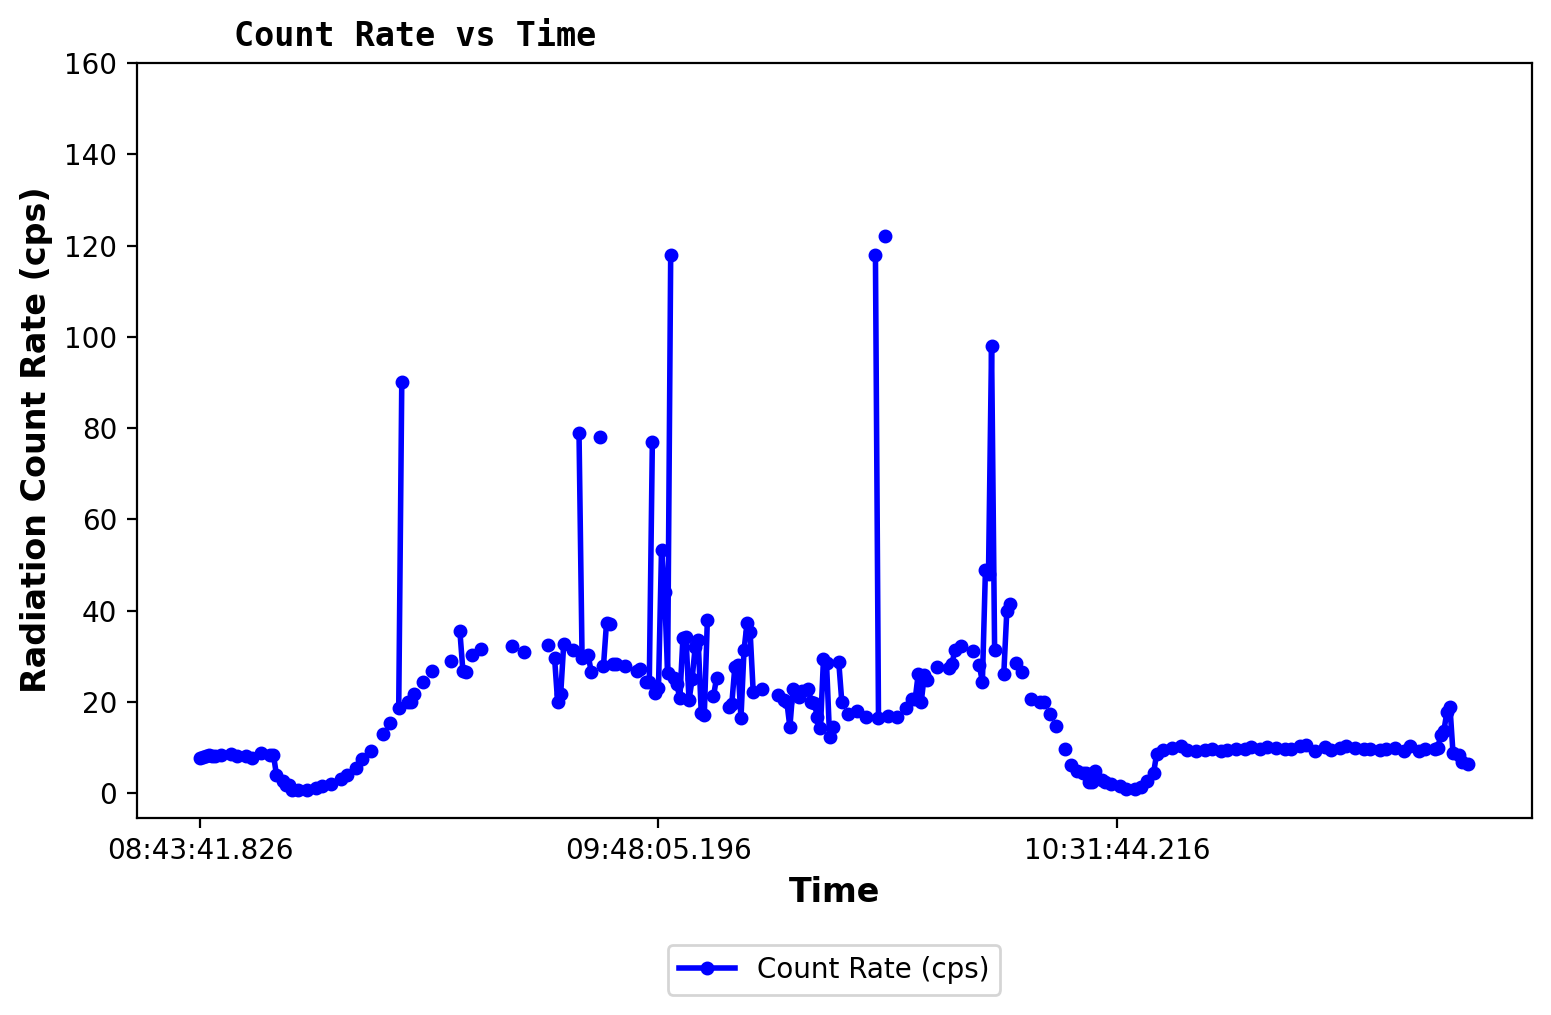

In [25]:
customPlot(df = geiger_df, 
           x_axis = ("Time", ""),
           x_col = "Just Time",
           left_y_axis = ("Radiation Count Rate", "cps"),
           left_y_cols = [("Count Rate: cps", "Count Rate", "blue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = None, 
           fills_index_offset = None, 
           reverse_and_log = False,
           x_ticks = 4)

In [26]:
# merging geiger with aprs 

def fixAPRSTime(utc):
    tokens = utc.split(":")
    return f"{(int(tokens[0])-7+24)%24}:{(int(tokens[1]))}:{(int(tokens[2]))}"


# print(list(geiger_df.columns))
geiger_aprs_df = aprs_df.copy()
cps = []
dose_rate = [] 
dose_rate_error = []

geiger_index = 0
aprs_time = datetime.datetime.strptime(fixAPRSTime((geiger_aprs_df["time"][0]).split()[1]), "%H:%M:%S")
geiger_time = datetime.datetime.strptime(geiger_df["Time"][geiger_index].split()[1].split(".")[0], "%H:%M:%S")
print("Geiger first:", geiger_time)

while geiger_time < aprs_time:
    geiger_index += 1
    geiger_time = datetime.datetime.strptime(geiger_df["Time"][geiger_index].split()[1].split(".")[0], "%H:%M:%S")

print("Geiger Time\t", "APRS Time")
print(geiger_time, aprs_time)    

for i in range(len(geiger_aprs_df["time"])):
    # for each time if it
    
    if str(geiger_aprs_df["time"][i]) == "nan" or geiger_index >= len(geiger_df["Time"]):
        cps.append(np.nan)
        dose_rate.append(np.nan)
        dose_rate_error.append(np.nan)
        continue
        
    aprs_time = datetime.datetime.strptime(fixAPRSTime((geiger_aprs_df["time"][i]).split()[1]), "%H:%M:%S")
    geiger_time = datetime.datetime.strptime(geiger_df["Time"][geiger_index].split()[1].split(".")[0], "%H:%M:%S")
    
#     print(geiger_time, aprs_time)
    if geiger_time < aprs_time:
        while geiger_time < aprs_time:
            geiger_index += 1
            geiger_time = datetime.datetime.strptime(geiger_df["Time"][geiger_index].split()[1].split(".")[0], "%H:%M:%S")
        
        cps.append(geiger_df["Count Rate: cps"][geiger_index])
        dose_rate.append(geiger_df["Dose rate: Sv/h"][geiger_index])
        dose_rate_error.append(geiger_df["Dose Rate Error: %"][geiger_index])
#         print("Attached", geiger_df["Time"][geiger_index], "to APRS Time", geiger_aprs_df["time"][i], f"({fixAPRSTime((geiger_aprs_df['time'][i]).split()[1])})")
        
        geiger_index += 1
    else:
        cps.append(np.nan)
        dose_rate.append(np.nan)
        dose_rate_error.append(np.nan)

print("Successfully merged", geiger_index, "geiger readings")

geiger_aprs_df["cps"] = cps
geiger_aprs_df["dose rate"] = dose_rate
geiger_aprs_df["dose rate error"] = dose_rate_error


Geiger first: 1900-01-01 08:43:41
Geiger Time	 APRS Time
1900-01-01 09:06:05 1900-01-01 09:05:26
Successfully merged 256 geiger readings


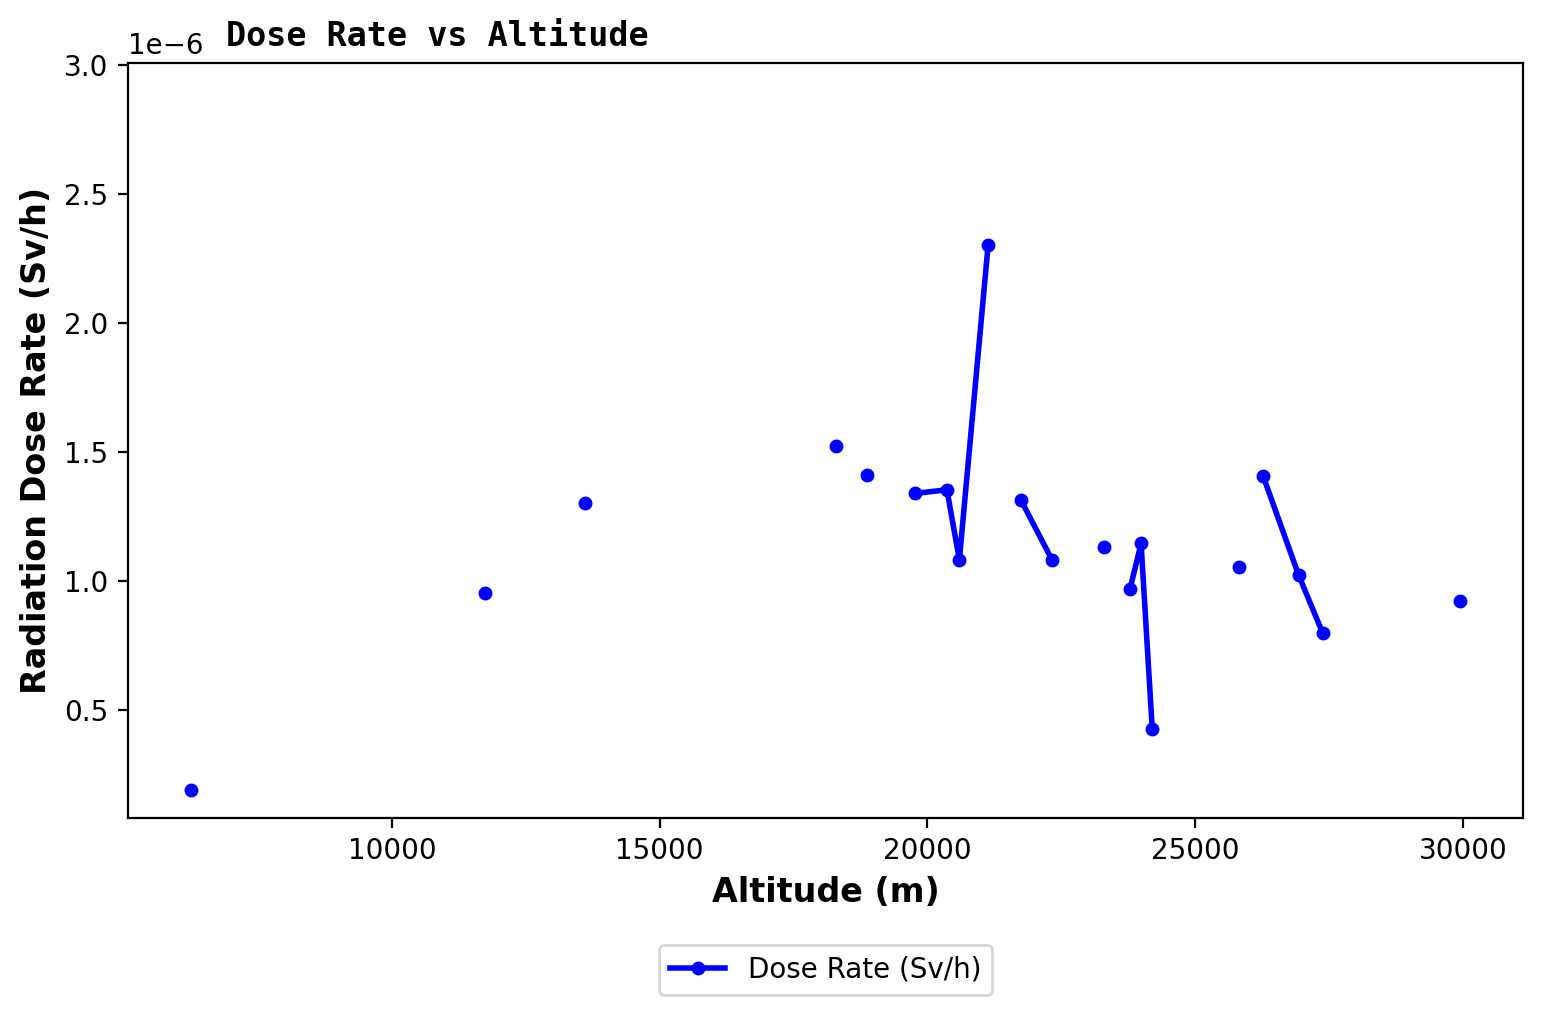

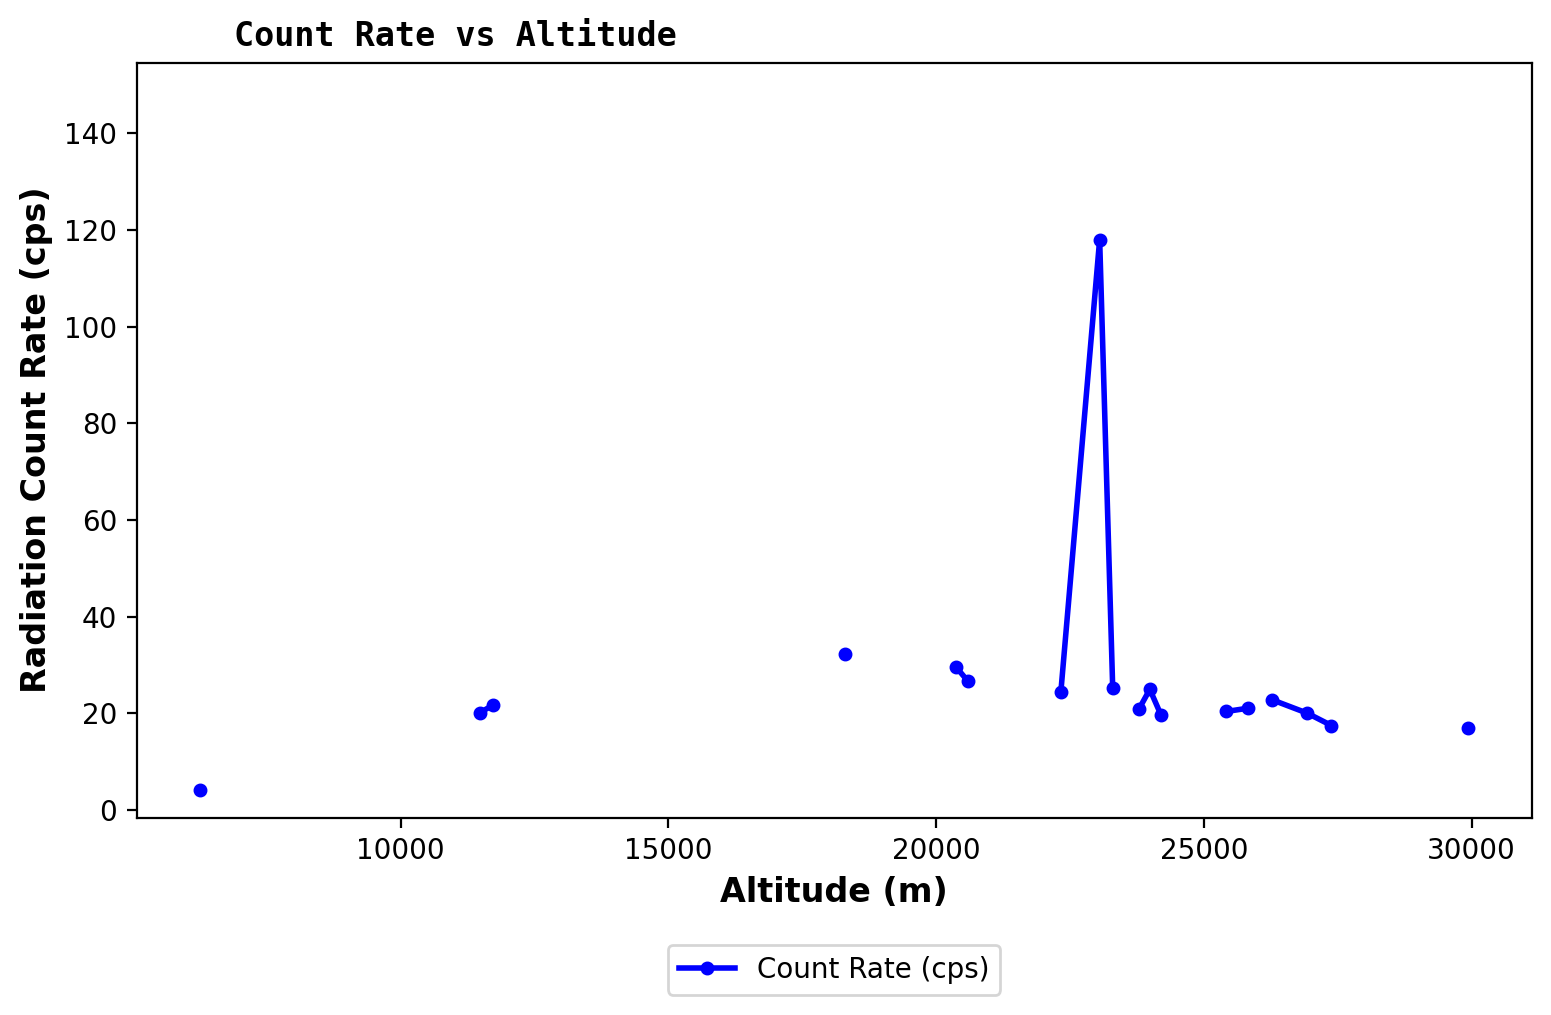

In [27]:
# dose rate
customPlot(df = geiger_aprs_df, 
           x_axis = ("Altitude", "m"),
           x_col = "altitude",
           left_y_axis = ("Radiation Dose Rate", "Sv/h"),
           left_y_cols = [("dose rate", "Dose Rate", "blue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = None, 
           fills_index_offset = 0, 
           reverse_and_log = False)

customPlot(df = geiger_aprs_df, 
           x_axis = ("Altitude", "m"),
           x_col = "altitude",
           left_y_axis = ("Radiation Count Rate", "cps"),
           left_y_cols = [("cps", "Count Rate", "blue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = None, 
           fills_index_offset = 0, 
           reverse_and_log = False)
